In [304]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score # для решения задач классификации (binary classification...)
from sklearn.metrics import mean_absolute_error, mean_squared_error # для решения задач регрессии (RUL)
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from keras.optimizers import SGD

In [305]:
# Закладка семян для воспроизводимости
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [306]:
# Подготовка обучающей даты

# Чтение обучающей даты
train_df = pd.read_csv('./data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [307]:
# Подготовка тестировочной даты

# Чтение тестировочной даты
test_df = pd.read_csv('./data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [308]:
# Подготовка правдивой даты

# Чтение правдивой даты
truth_df = pd.read_csv('./data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [309]:
# Создание столбца RUL для обучающих данных

# Создание DataFrame с максимальными значениями 'cycle' для каждого 'id'
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Задание названий столбцов для DataFrame 'rul'
rul.columns = ['id', 'max']

# Слияние DataFrame 'train_df' с DataFrame 'rul' по столбцу 'id'
train_df = train_df.merge(rul, on=['id'], how='left')

# Создание столбца 'RUL', содержащего разницу между 'max' и 'cycle'
train_df['RUL'] = train_df['max'] - train_df['cycle']

# Удаление столбца 'max' из DataFrame 'train_df'
train_df.drop('max', axis=1, inplace=True)

In [310]:
# Генерация столбцов меток для обучающих данных
w1 = 30  # Задание значения для порога w1
w0 = 15  # Задание значения для порога w0

# Создание столбца 'label1'. Если 'RUL' меньше или равно w1, то значение становится 1, иначе 0
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0)

# Создание столбца 'label2', который копирует значения из 'label1'
train_df['label2'] = train_df['label1']

# Обновление значений столбца 'label2'. Если 'RUL' меньше или равно w0, то значение становится 2
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [311]:
# MinMax нормализация обучающих данных
train_df['cycle_norm'] = train_df['cycle']  # Создание нового столбца 'cycle_norm', который копирует значения из столбца 'cycle'

# Определение столбцов для нормализации, исключая ненужные столбцы
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

# Создание экземпляра MinMaxScaler для нормализации данных
min_max_scaler = preprocessing.MinMaxScaler()

# Нормализация выбранных столбцов с помощью метода fit_transform
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

# Объединение нормализованных данных с исходными данными
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)

# Обновление DataFrame train_df с объединенными данными и переиндексацией столбцов
train_df = join_df.reindex(columns = train_df.columns)

In [312]:
# MinMax нормализация тренировочных данных

# Создание нового столбца 'cycle_norm', который копирует значения из столбца 'cycle' в test_df
test_df['cycle_norm'] = test_df['cycle']

# Нормализация тестовых данных test_df с помощью метода transform
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)

# Объединение нормализованных данных с оставшимися данными в test_df
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)

# Обновление DataFrame test_df с объединенными данными и переиндексацией столбцов
test_df = test_join_df.reindex(columns=test_df.columns)

# Сброс индексов источника данных для обучения и удаление старых индексов из test_df
test_df = test_df.reset_index(drop=True)

In [313]:
# Создание столбца RUL и столбцов меток для тестировочных данных

# Создание столбца 'max' для тестовых данных
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

# Задание названий столбцов для DataFrame 'rul'
rul.columns = ['id', 'max']

# Изменение названия столбца в DataFrame 'truth_df'
truth_df.columns = ['more']

# Создание столбца 'id' в DataFrame 'truth_df' с помощью индексов и увеличение его значений на 1
truth_df['id'] = truth_df.index + 1

# Создание столбца 'max' в DataFrame 'truth_df', который является суммой 'max' из DataFrame 'rul' и столбца 'more' из DataFrame 'truth_df'
truth_df['max'] = rul['max'] + truth_df['more']

# Удаление столбца 'more' из DataFrame 'truth_df'
truth_df.drop('more', axis=1, inplace=True)

# Генерация столбца 'RUL' в test_df, который представляет разницу между 'max' и 'cycle'
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']

# Удаление столбца 'max' из DataFrame 'test_df'
test_df.drop('max', axis=1, inplace=True)

# Генерация столбцов меток 'label1' и 'label2' для тестовых данных, используя пороговые значения w0 и w1
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0)  # Значение 1, если 'RUL' меньше или равно w1, в противном случае 0
test_df['label2'] = test_df['label1']  # Копирование значений из 'label1' в 'label2'

# Обновление значений в столбце 'label2'. Если 'RUL' меньше или равно w0, то значение становится 2
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [314]:
# Выбираем большой размер окна в 50 циклов
sequence_length = 125

In [315]:
# Функция для преобразования признаков в формат (образцы, временные шаги, признаки)
def gen_sequence(id_df, seq_length, seq_cols):
    """
    Функция gen_sequence принимает следующие аргументы:
    id_df: DataFrame, который содержит данные для конкретного идентификатора
    seq_length: длина последовательности
    seq_cols: список столбцов, используемых для создания последовательности
    """
    """ Рассматриваются только последовательности, которые соответствуют длине окна, без использования заполнения.
    Это означает, что при тестировании нам нужно исключить те, которые находятся ниже длины окна. 
    Альтернативой могло бы быть заполнение последовательностей, чтобы мы могли использовать более короткие """

    data_array = id_df[seq_cols].values  # Извлечение значений из DataFrame в массив
    num_elements = data_array.shape[0]  # Получение количества элементов в массиве

    # Цикл для создания последовательностей
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        # Генерация последовательности от start до stop из массива данных

In [316]:
# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# Определение столбцов признаков
sequence_cols = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21', 'cycle_norm']


In [317]:
# Генератор для последовательностей
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [318]:
# Генерация последовательностей и преобразование их в массив numpy
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)  # Объединение списка последовательностей в один массив numpy и преобразование в тип данных np.float32
seq_array.shape  # Вывод формы массива

(8131, 125, 16)

In [319]:
# Функция для генерации меток
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values  # Извлечение значений меток из DataFrame в массив
    num_elements = data_array.shape[0]  # Получение количества элементов в массиве
    return data_array[seq_length:num_elements,
           :]  # Возвращение значений меток, начиная с индекса seq_length и до конца массива

In [320]:
# Генерация меток (RUL)
label_rul_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]  # Генерация меток для каждого идентификатора в train_df
label_rul_array = np.concatenate(label_rul_gen).astype(np.float32)  # Объединение списка меток в один массив numpy и преобразование в тип данных np.float32
label_rul_array.shape  # Вывод формы массива меток

(8131, 1)

In [321]:
label_rul_array

array([[66.],
       [65.],
       [64.],
       ...,
       [ 2.],
       [ 1.],
       [ 0.]], dtype=float32)

__Создаем вспомогательную функцию для вычисления метрик регрессии__

In [322]:
def get_regression_metrics(model, actual, predicted):
    
    """Вычисляет основные метрики регрессии.
    
    Args:
        model (str): Идентификатор названия модели
        actual (series): Содержит фактические значения меток теста
        predicted (series): Содержит предсказанные значения
        
    Returns:
        dataframe: Объединенные метрики в одном фрейме данных
    
    """
    # Словарь для хранения метрик регрессии
    regr_metrics = {
        'Root Mean Squared Error': metrics.mean_squared_error(actual, predicted) ** 0.5,
        'Mean Absolute Error': metrics.mean_absolute_error(actual, predicted),
        'R^2': metrics.r2_score(actual, predicted),
        'Explained Variance': metrics.explained_variance_score(actual, predicted)
    }

    # Создаем DataFrame из словаря метрик
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    
    # Задаем название столбца как имя модели
    df_regr_metrics.columns = [model]
    
    return df_regr_metrics

__Создаем вспомогательную функцию для построения графика весов коэффициентов или важности признаков__

In [323]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Строит график весов коэффициентов регрессии или важности признаков.
    
    Args:
        model (str): Идентификатор названия модели
        weights (array): Содержит веса коэффициентов регрессии или важности признаков
        feature_names (list): Содержит соответствующие имена признаков
        weights_type (str): 'c' для 'весов коэффициентов', в противном случае - 'важность признаков'
        
    Returns:
        График весов коэффициентов регрессии или важности признаков
    
    """
    # Определение размеров графика в зависимости от количества признаков
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    
    # Создание DataFrame из весов и имен признаков
    W = pd.DataFrame({'Weights': weights}, feature_names)
    
    # Построение горизонтальной столбчатой диаграммы
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px, py))
    
    # Определение подписи в зависимости от типа весов
    label = ' Coefficients' if weights_type == 'c' else ' Features Importance'
    
    # Установка подписи оси x и удаление легенды
    plt.xlabel(model + label)
    plt.gca().legend_ = None

__Создаем вспомогательную функцию для построения графика остатков регрессии__

In [324]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Выводит график остатков регрессии.
    
    Args:
        model (str): Идентификатор названия модели
        y_train (series): Обучающие метки
        y_train_pred (series): Прогнозы на обучающих данных
        y_test (series): Тестовые метки
        y_test_pred (series): Прогнозы на тестовых данных
        
    Returns:
        График остатков регрессии
    
    """
    
    # Рассеиваемые диаграммы остатков для обучающих и тестовых данных
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    
    # Настройка подписей и легенды
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    
    # Горизонтальная линия на уровне 0 (для отображения точек вокруг 0)
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    
    # Название графика
    plt.title(model + ' Residuals')
    
    # Отображение графика
    plt.show()

In [325]:
### Важно примечание по настройке гиперпараметров:

# Вот несколько рекомендаций и идей для настройки гиперпараметров:
# 
#     1) Количество эпох обучения:
# 
#         Увеличьте или уменьшите количество эпох обучения в зависимости от того, как изменения влияют на обучение модели.
#         Может потребоваться больше эпох для того, чтобы модель достигла сходимости.
# 
#         # Пример: Увеличение числа эпох
#         model.fit(seq_array, label_rul_array, epochs=50, batch_size=100, validation_split=0.1, verbose=1, 
#         callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
# 
#     2) Количество слоев и нейронов:
# 
#         Экспериментируйте с количеством слоев и нейронов в каждом слое. Больше слоев или нейронов могут 
#         помочь модели изучить более сложные паттерны, но это также может привести к переобучению.
# 
#         # Пример: Добавление слоя LSTM
#         model.add(LSTM(units=100, return_sequences=True))
# 
#     3) Коэффициент Dropout:
# 
#         Попробуйте изменить коэффициент Dropout в слоях, чтобы уменьшить переобучение.
# 
#         # Пример: Изменение коэффициента Dropout
#             model.add(Dropout(0.3))
# 
#     4) Оптимизатор:
# 
#         Попробуйте различные оптимизаторы (например, 'adam', 'rmsprop', 'sgd').
# 
#         # Пример: Изменение оптимизатора
#             model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_absolute_error'])
# 
#     5) Размер батча:
#         Измените размер батча и оцените, как это влияет на производительность.
# 
#         # Пример: Изменение размера батча
#         model.fit(seq_array, label_rul_array, epochs=25, batch_size=50, validation_split=0.1, verbose=1, 
#           callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
# 
#     6) Функция активации:
#         Измените функцию активации в последнем слое в зависимости от типа задачи (например, 'linear' для регрессии, 'sigmoid' для бинарной классификации).
# 
#         # Пример: Изменение функции активации
#         model.add(Dense(units=nb_out, activation='linear'))


# для построения графиков 1) значение функции потерь (val loss) и 2) точность (accuracy) в процессе обучения модели

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('mean_squared_error')
  ax1.grid(True)

  ax2.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  ax2.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('mean_absolute_error')
  ax2.grid(True)

  plt.show()

# построение оптимальной модели с подобором гиперпараметров с помощью метода Grid Search

def train_model(X_train, y_train, units, dropout_rate, optimizer, learning_rate, batch_size, epochs, validation_split):
    # Построение нейронной сети
    nb_features = X_train.shape[2]  # Получение количества признаков из размерности seq_array
    nb_out = y_train.shape[1]  # Получение количества выходных переменных из размерности label_array
    
    model = Sequential()  # Инициализация последовательной модели
    
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=units,
             return_sequences=True))  # Добавление слоя LSTM с 100 юнитами, возвращающего последовательности
    model.add(Dropout(dropout_rate))  # Добавление слоя Dropout для регуляризации
    
    model.add(LSTM(
              units=units,
              return_sequences=False))  # Добавление слоя LSTM с 50 юнитами, не возвращающего последовательности
    model.add(Dropout(dropout_rate))  # Добавление слоя Dropout для регуляризации
    
    model.add(Dense(units=nb_out, activation='linear'))  # Добавление полносвязного слоя с активацией linear
    optimizer_str = f"""{optimizer}"""
    model.compile(loss='mean_squared_error', optimizer=optimizer_str, metrics=['mean_absolute_error'])  # Компиляция модели с выбранной функцией потерь, оптимизатором и метриками
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

    return model, history


units: 50, dropout: 0, batch size: 32, optimizer: SGD, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 15s 52ms/step - loss: 1618.0168 - mean_absolute_error: 30.3016 - val_loss: 1116.2179 - val_mean_absolute_error: 24.4129
Epoch 2/100
229/229 [==============================] - 12s 53ms/step - loss: 719.0392 - mean_absolute_error: 18.7706 - val_loss: 1070.2272 - val_mean_absolute_error: 22.6097
Epoch 3/100
229/229 [==============================] - 12s 53ms/step - loss: 644.1770 - mean_absolute_error: 17.3755 - val_loss: 840.1541 - val_mean_absolute_error: 21.2323
Epoch 4/100
229/229 [==============================] - 12s 53ms/step - loss: 646.2277 - mean_absolute_error: 17.4195 - val_loss: 1734.9240 - val_mean_absolute_error: 28.0094


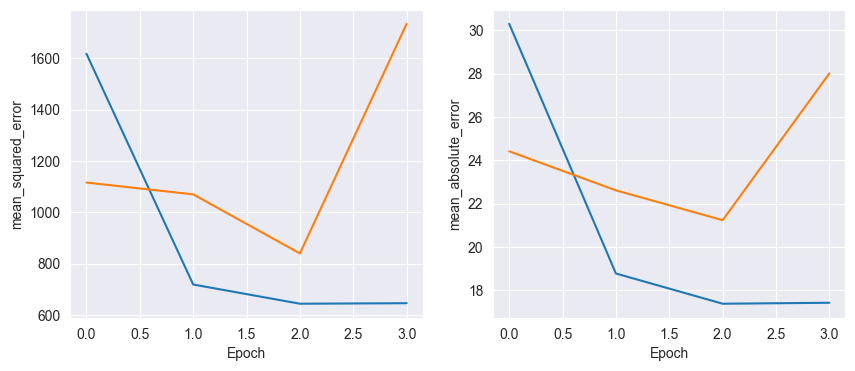

255/255 [==============================] - 5s 19ms/step - loss: 997.7029 - mean_absolute_error: 20.4606
units: 50, dropout: 0, batch size: 32, optimizer: SGD, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 13s 52ms/step - loss: 1443.6276 - mean_absolute_error: 28.5074 - val_loss: 1953.3123 - val_mean_absolute_error: 31.2591
Epoch 2/100
204/204 [==============================] - 12s 59ms/step - loss: 643.8112 - mean_absolute_error: 17.5269 - val_loss: 1001.5908 - val_mean_absolute_error: 22.4883
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 572.6907 - mean_absolute_error: 16.2100 - val_loss: 1230.8074 - val_mean_absolute_error: 26.0385


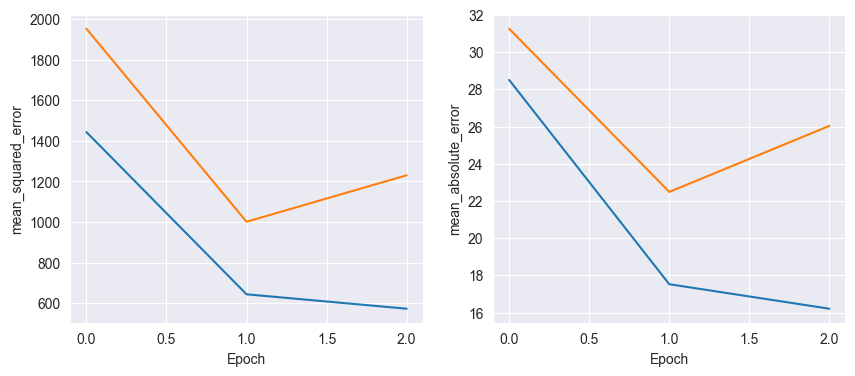

255/255 [==============================] - 5s 19ms/step - loss: 736.4898 - mean_absolute_error: 20.1619
units: 50, dropout: 0, batch size: 64, optimizer: SGD, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 12s 87ms/step - loss: 1761.1906 - mean_absolute_error: 31.9254 - val_loss: 1674.7715 - val_mean_absolute_error: 29.8636
Epoch 2/100
115/115 [==============================] - 10s 85ms/step - loss: 855.3322 - mean_absolute_error: 20.8020 - val_loss: 2721.4084 - val_mean_absolute_error: 37.0848


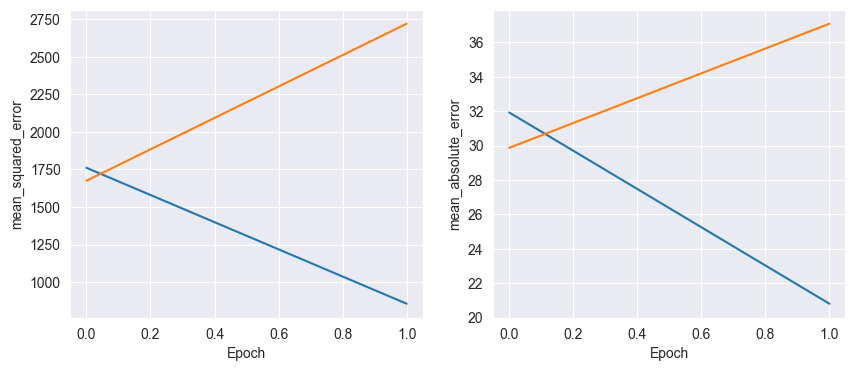

255/255 [==============================] - 4s 17ms/step - loss: 1690.2419 - mean_absolute_error: 27.9537
units: 50, dropout: 0, batch size: 64, optimizer: SGD, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 12s 91ms/step - loss: 1652.0723 - mean_absolute_error: 31.1811 - val_loss: 2708.7305 - val_mean_absolute_error: 42.1855
Epoch 2/100
102/102 [==============================] - 9s 85ms/step - loss: 1555.7903 - mean_absolute_error: 30.4512 - val_loss: 4098.8657 - val_mean_absolute_error: 46.5073


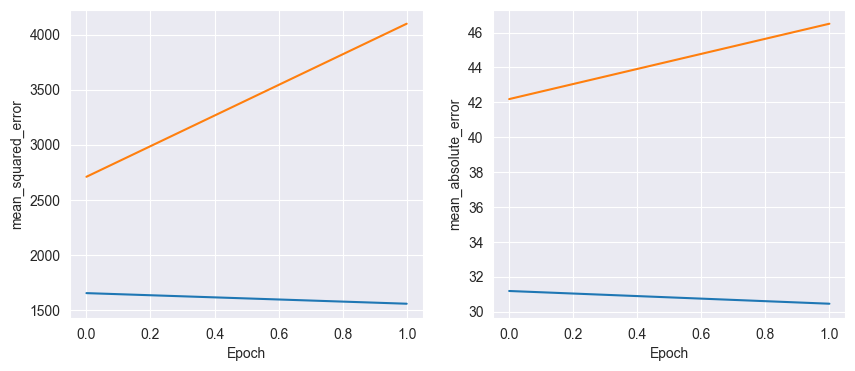

255/255 [==============================] - 5s 18ms/step - loss: 2399.4402 - mean_absolute_error: 34.4502
units: 50, dropout: 0, batch size: 128, optimizer: SGD, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 10s 127ms/step - loss: 1892.8264 - mean_absolute_error: 33.3156 - val_loss: 2689.5691 - val_mean_absolute_error: 42.6340
Epoch 2/100
58/58 [==============================] - 7s 128ms/step - loss: 1681.5386 - mean_absolute_error: 31.4650 - val_loss: 2609.7810 - val_mean_absolute_error: 40.7919
Epoch 3/100
58/58 [==============================] - 8s 134ms/step - loss: 1058.1791 - mean_absolute_error: 23.9518 - val_loss: 845.9578 - val_mean_absolute_error: 21.3049
Epoch 4/100
58/58 [==============================] - 7s 129ms/step - loss: 762.3215 - mean_absolute_error: 19.3509 - val_loss: 765.3516 - val_mean_absolute_error: 19.9921
Epoch 5/100
58/58 [==============================] - 8s 132ms/step - loss: 723.6913 - mean_absolute_error: 18.6553 - val_loss: 

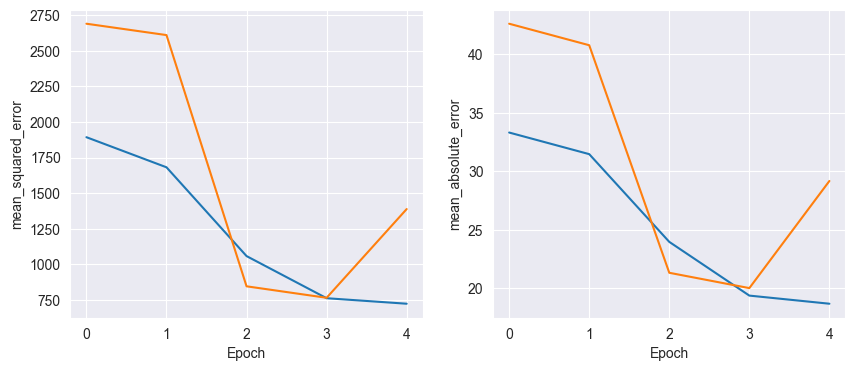

255/255 [==============================] - 4s 17ms/step - loss: 943.3689 - mean_absolute_error: 23.7548
units: 50, dropout: 0, batch size: 128, optimizer: SGD, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 10s 134ms/step - loss: 1699.5553 - mean_absolute_error: 31.6319 - val_loss: 3060.9451 - val_mean_absolute_error: 41.7573
Epoch 2/100
51/51 [==============================] - 6s 120ms/step - loss: 1568.5017 - mean_absolute_error: 30.4340 - val_loss: 3656.2913 - val_mean_absolute_error: 44.1414


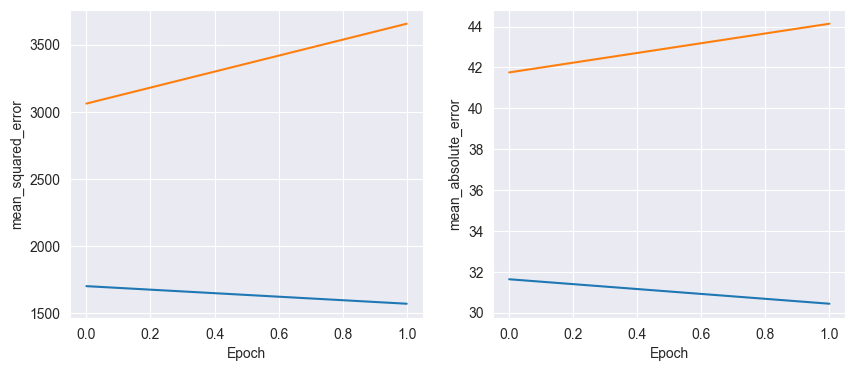

255/255 [==============================] - 4s 17ms/step - loss: 2134.1404 - mean_absolute_error: 32.8203
units: 50, dropout: 0, batch size: 32, optimizer: Adam, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 15s 52ms/step - loss: 3221.4766 - mean_absolute_error: 40.9648 - val_loss: 4635.3027 - val_mean_absolute_error: 48.8109
Epoch 2/100
229/229 [==============================] - 13s 55ms/step - loss: 2455.7751 - mean_absolute_error: 34.8257 - val_loss: 3893.3408 - val_mean_absolute_error: 44.7293
Epoch 3/100
229/229 [==============================] - 13s 56ms/step - loss: 2075.9893 - mean_absolute_error: 32.4545 - val_loss: 3440.5142 - val_mean_absolute_error: 42.7968
Epoch 4/100
229/229 [==============================] - 13s 56ms/step - loss: 1880.1575 - mean_absolute_error: 31.6222 - val_loss: 3166.2710 - val_mean_absolute_error: 41.9174
Epoch 5/100
229/229 [==============================] - 13s 55ms/step - loss: 1790.8889 - mean_absolute_error: 31.5763

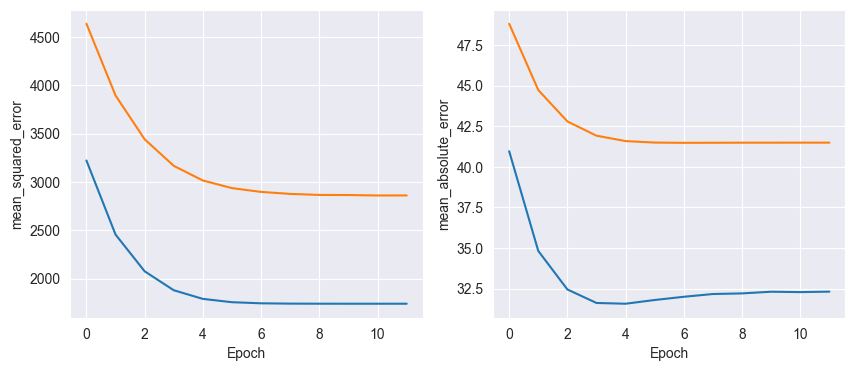

255/255 [==============================] - 5s 20ms/step - loss: 1852.9355 - mean_absolute_error: 33.2272
units: 50, dropout: 0, batch size: 32, optimizer: Adam, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 14s 54ms/step - loss: 3064.8723 - mean_absolute_error: 40.3983 - val_loss: 5086.5015 - val_mean_absolute_error: 52.2919
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 2337.4868 - mean_absolute_error: 34.1104 - val_loss: 4310.8818 - val_mean_absolute_error: 47.6396
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 1964.9473 - mean_absolute_error: 31.4197 - val_loss: 3797.6306 - val_mean_absolute_error: 44.9528
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 1759.0013 - mean_absolute_error: 30.3271 - val_loss: 3471.2544 - val_mean_absolute_error: 43.4418
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 1654.6023 - mean_absolute_error: 30.0451

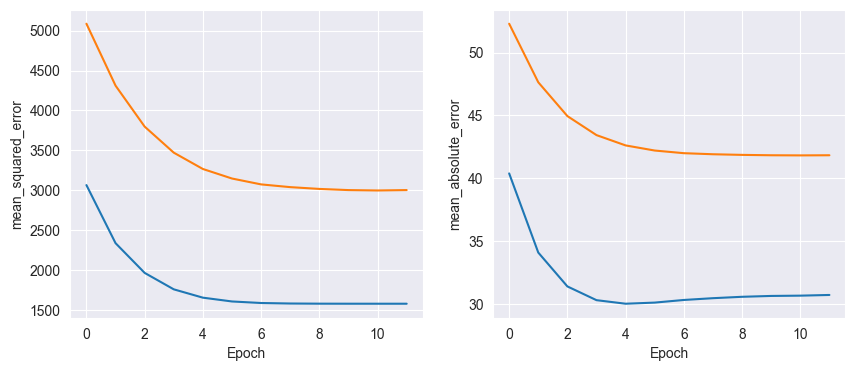

255/255 [==============================] - 5s 20ms/step - loss: 1863.5371 - mean_absolute_error: 32.9251
units: 50, dropout: 0, batch size: 64, optimizer: Adam, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 13s 86ms/step - loss: 3452.9575 - mean_absolute_error: 42.9387 - val_loss: 5094.6626 - val_mean_absolute_error: 51.7328
Epoch 2/100
115/115 [==============================] - 10s 86ms/step - loss: 2870.0156 - mean_absolute_error: 38.0004 - val_loss: 4570.7188 - val_mean_absolute_error: 48.4191
Epoch 3/100
115/115 [==============================] - 10s 87ms/step - loss: 2541.8401 - mean_absolute_error: 35.4298 - val_loss: 4166.7769 - val_mean_absolute_error: 46.1147
Epoch 4/100
115/115 [==============================] - 10s 86ms/step - loss: 2296.9187 - mean_absolute_error: 33.7515 - val_loss: 3846.5557 - val_mean_absolute_error: 44.5112
Epoch 5/100
115/115 [==============================] - 10s 86ms/step - loss: 2116.0051 - mean_absolute_error: 32.6510

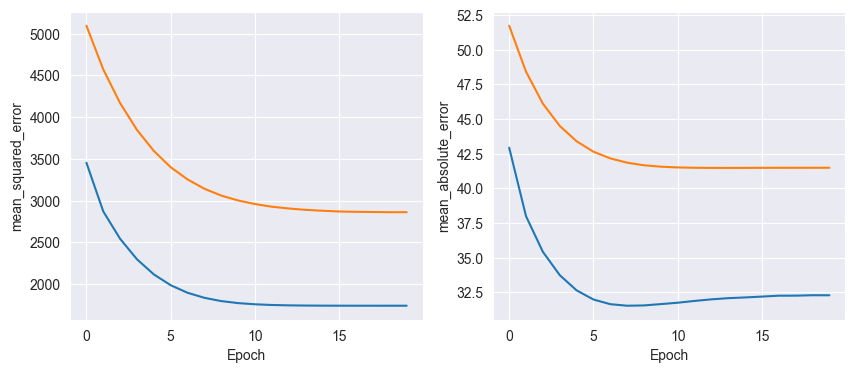

255/255 [==============================] - 5s 18ms/step - loss: 1853.0377 - mean_absolute_error: 33.2214
units: 50, dropout: 0, batch size: 64, optimizer: Adam, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 12s 93ms/step - loss: 3244.1750 - mean_absolute_error: 41.9597 - val_loss: 5477.2163 - val_mean_absolute_error: 54.8231
Epoch 2/100
102/102 [==============================] - 9s 89ms/step - loss: 2683.6355 - mean_absolute_error: 36.9268 - val_loss: 4964.3467 - val_mean_absolute_error: 51.5236
Epoch 3/100
102/102 [==============================] - 9s 89ms/step - loss: 2385.8796 - mean_absolute_error: 34.4514 - val_loss: 4545.8589 - val_mean_absolute_error: 48.9842
Epoch 4/100
102/102 [==============================] - 9s 89ms/step - loss: 2152.0447 - mean_absolute_error: 32.6519 - val_loss: 4206.5317 - val_mean_absolute_error: 47.0630
Epoch 5/100
102/102 [==============================] - 9s 91ms/step - loss: 1977.6720 - mean_absolute_error: 31.4675 - v

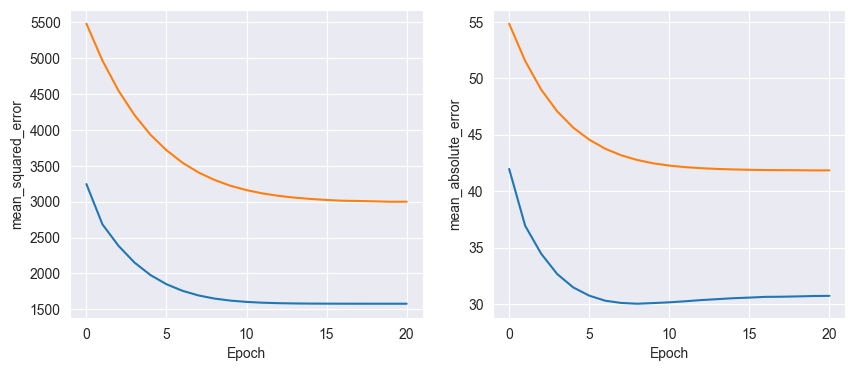

255/255 [==============================] - 5s 20ms/step - loss: 1862.8376 - mean_absolute_error: 32.9365
units: 50, dropout: 0, batch size: 128, optimizer: Adam, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 10s 124ms/step - loss: 3866.6855 - mean_absolute_error: 46.6091 - val_loss: 5630.5825 - val_mean_absolute_error: 55.3895
Epoch 2/100
58/58 [==============================] - 7s 126ms/step - loss: 3335.2385 - mean_absolute_error: 41.8701 - val_loss: 5264.2959 - val_mean_absolute_error: 52.8639
Epoch 3/100
58/58 [==============================] - 7s 124ms/step - loss: 3084.6313 - mean_absolute_error: 39.7395 - val_loss: 4965.2773 - val_mean_absolute_error: 50.8855
Epoch 4/100
58/58 [==============================] - 7s 124ms/step - loss: 2878.4111 - mean_absolute_error: 38.0467 - val_loss: 4705.6509 - val_mean_absolute_error: 49.2425
Epoch 5/100
58/58 [==============================] - 7s 124ms/step - loss: 2701.4841 - mean_absolute_error: 36.6457 - val_l

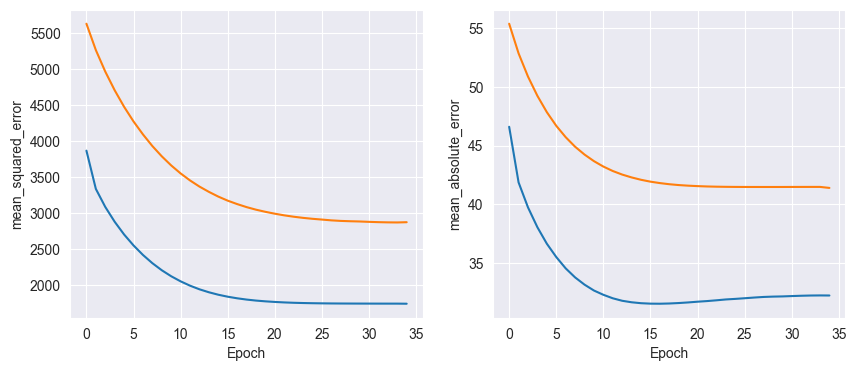

255/255 [==============================] - 5s 18ms/step - loss: 1848.5184 - mean_absolute_error: 33.0136
units: 50, dropout: 0, batch size: 128, optimizer: Adam, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 10s 138ms/step - loss: 3575.5913 - mean_absolute_error: 45.1188 - val_loss: 5971.8779 - val_mean_absolute_error: 58.1558
Epoch 2/100
51/51 [==============================] - 7s 129ms/step - loss: 3065.2395 - mean_absolute_error: 40.3179 - val_loss: 5596.6338 - val_mean_absolute_error: 55.6152
Epoch 3/100
51/51 [==============================] - 7s 130ms/step - loss: 2843.6758 - mean_absolute_error: 38.3240 - val_loss: 5308.5776 - val_mean_absolute_error: 53.7198
Epoch 4/100
51/51 [==============================] - 7s 130ms/step - loss: 2662.9868 - mean_absolute_error: 36.7484 - val_loss: 5057.6045 - val_mean_absolute_error: 52.1101
Epoch 5/100
51/51 [==============================] - 7s 129ms/step - loss: 2507.2026 - mean_absolute_error: 35.4366 - val_l

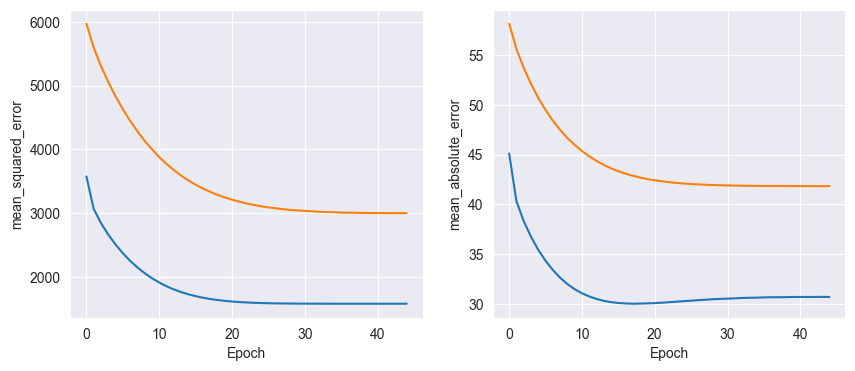

255/255 [==============================] - 5s 19ms/step - loss: 1863.3044 - mean_absolute_error: 32.9289
units: 50, dropout: 0, batch size: 32, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 15s 55ms/step - loss: 3246.5869 - mean_absolute_error: 41.2067 - val_loss: 4736.5762 - val_mean_absolute_error: 49.4345
Epoch 2/100
229/229 [==============================] - 13s 57ms/step - loss: 2487.5056 - mean_absolute_error: 35.0633 - val_loss: 3862.0686 - val_mean_absolute_error: 44.5837
Epoch 3/100
229/229 [==============================] - 13s 57ms/step - loss: 2019.4764 - mean_absolute_error: 32.1360 - val_loss: 3267.2031 - val_mean_absolute_error: 42.2094
Epoch 4/100
229/229 [==============================] - 13s 58ms/step - loss: 1793.6068 - mean_absolute_error: 31.5858 - val_loss: 2962.6370 - val_mean_absolute_error: 41.5187
Epoch 5/100
229/229 [==============================] - 13s 57ms/step - loss: 1746.1659 - mean_absolute_error: 32.0

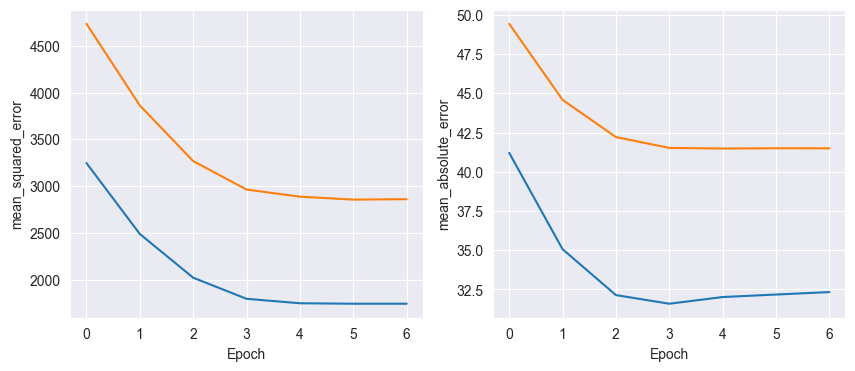

255/255 [==============================] - 5s 20ms/step - loss: 1852.8597 - mean_absolute_error: 33.2316
units: 50, dropout: 0, batch size: 32, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 14s 57ms/step - loss: 2853.2334 - mean_absolute_error: 38.4684 - val_loss: 4888.9106 - val_mean_absolute_error: 51.0528
Epoch 2/100
204/204 [==============================] - 12s 61ms/step - loss: 2202.9370 - mean_absolute_error: 33.0798 - val_loss: 4060.6165 - val_mean_absolute_error: 46.2857
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 1818.2505 - mean_absolute_error: 30.6171 - val_loss: 3467.0720 - val_mean_absolute_error: 43.4242
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 1631.1948 - mean_absolute_error: 30.0896 - val_loss: 3131.7283 - val_mean_absolute_error: 42.1697
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 1584.3116 - mean_absolute_error: 30.4

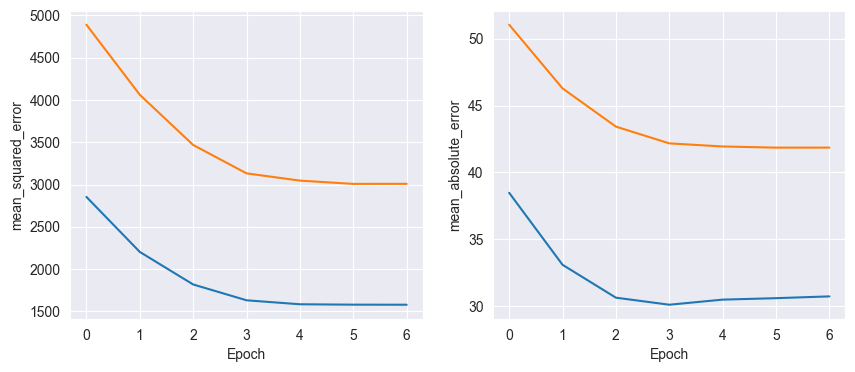

255/255 [==============================] - 5s 20ms/step - loss: 1864.7123 - mean_absolute_error: 32.9068
units: 50, dropout: 0, batch size: 64, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 17s 117ms/step - loss: 3394.5425 - mean_absolute_error: 42.4508 - val_loss: 5118.1616 - val_mean_absolute_error: 51.8878
Epoch 2/100
115/115 [==============================] - 11s 99ms/step - loss: 2889.5901 - mean_absolute_error: 38.1325 - val_loss: 4586.6499 - val_mean_absolute_error: 48.5136
Epoch 3/100
115/115 [==============================] - 12s 101ms/step - loss: 2530.7100 - mean_absolute_error: 35.3807 - val_loss: 4122.9023 - val_mean_absolute_error: 45.8818
Epoch 4/100
115/115 [==============================] - 12s 101ms/step - loss: 2245.0266 - mean_absolute_error: 33.4030 - val_loss: 3731.4951 - val_mean_absolute_error: 43.9879
Epoch 5/100
115/115 [==============================] - 11s 96ms/step - loss: 2031.5853 - mean_absolute_error: 3

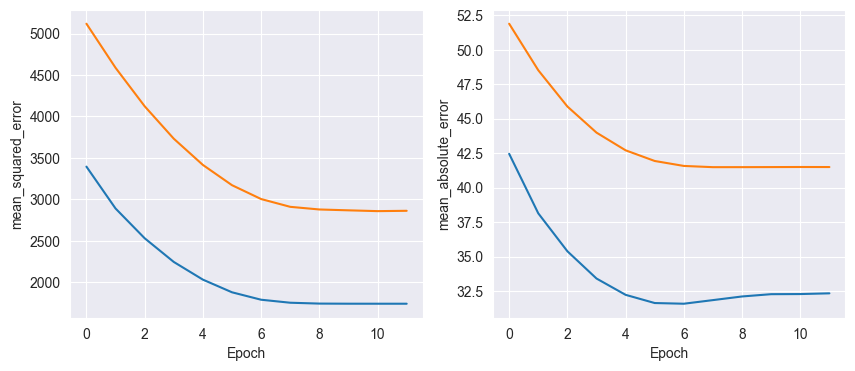

255/255 [==============================] - 5s 20ms/step - loss: 1853.0792 - mean_absolute_error: 33.2190
units: 50, dropout: 0, batch size: 64, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 14s 110ms/step - loss: 3073.1780 - mean_absolute_error: 40.3812 - val_loss: 5380.3545 - val_mean_absolute_error: 54.1859
Epoch 2/100
102/102 [==============================] - 10s 100ms/step - loss: 2627.0510 - mean_absolute_error: 36.4542 - val_loss: 4878.3843 - val_mean_absolute_error: 50.9886
Epoch 3/100
102/102 [==============================] - 10s 103ms/step - loss: 2322.6423 - mean_absolute_error: 33.9549 - val_loss: 4435.7324 - val_mean_absolute_error: 48.3455
Epoch 4/100
102/102 [==============================] - 11s 107ms/step - loss: 2075.4800 - mean_absolute_error: 32.1154 - val_loss: 4047.7075 - val_mean_absolute_error: 46.2190
Epoch 5/100
102/102 [==============================] - 10s 102ms/step - loss: 1881.4846 - mean_absolute_error:

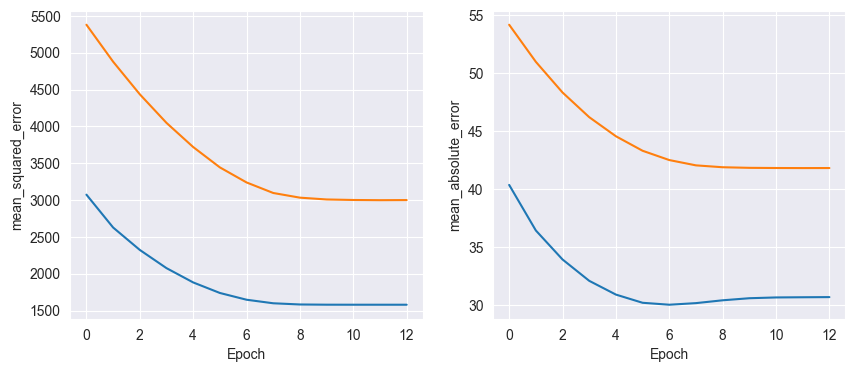

255/255 [==============================] - 5s 21ms/step - loss: 1862.9546 - mean_absolute_error: 32.9345
units: 50, dropout: 0, batch size: 128, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 11s 130ms/step - loss: 3628.4717 - mean_absolute_error: 44.5061 - val_loss: 5484.5098 - val_mean_absolute_error: 54.3704
Epoch 2/100
58/58 [==============================] - 7s 127ms/step - loss: 3244.1372 - mean_absolute_error: 41.0922 - val_loss: 5172.1230 - val_mean_absolute_error: 52.2460
Epoch 3/100
58/58 [==============================] - 7s 128ms/step - loss: 3023.7180 - mean_absolute_error: 39.2347 - val_loss: 4891.1509 - val_mean_absolute_error: 50.4098
Epoch 4/100
58/58 [==============================] - 9s 152ms/step - loss: 2824.7563 - mean_absolute_error: 37.6270 - val_loss: 4630.6777 - val_mean_absolute_error: 48.7827
Epoch 5/100
58/58 [==============================] - 9s 153ms/step - loss: 2642.5439 - mean_absolute_error: 36.1908 - va

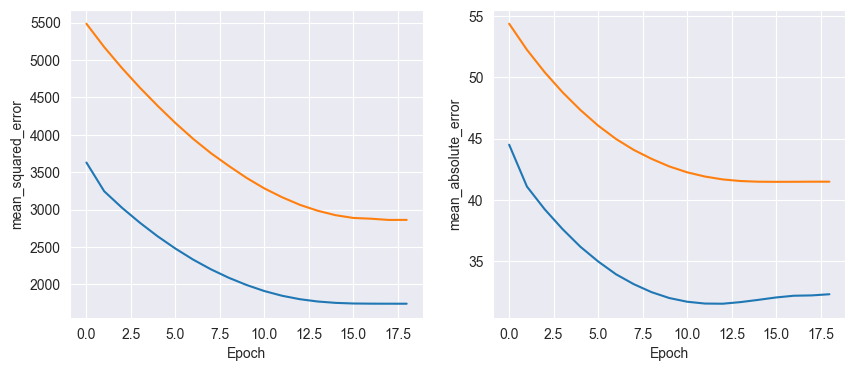

255/255 [==============================] - 5s 18ms/step - loss: 1853.0867 - mean_absolute_error: 33.2185
units: 50, dropout: 0, batch size: 128, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 10s 143ms/step - loss: 3315.3201 - mean_absolute_error: 42.6371 - val_loss: 5781.6987 - val_mean_absolute_error: 56.8600
Epoch 2/100
51/51 [==============================] - 6s 127ms/step - loss: 2965.7805 - mean_absolute_error: 39.4173 - val_loss: 5483.7241 - val_mean_absolute_error: 54.8656
Epoch 3/100
51/51 [==============================] - 7s 129ms/step - loss: 2777.5283 - mean_absolute_error: 37.7350 - val_loss: 5220.5728 - val_mean_absolute_error: 53.1509
Epoch 4/100
51/51 [==============================] - 6s 126ms/step - loss: 2606.6233 - mean_absolute_error: 36.2776 - val_loss: 4971.5669 - val_mean_absolute_error: 51.5682
Epoch 5/100
51/51 [==============================] - 6s 126ms/step - loss: 2449.7610 - mean_absolute_error: 34.9677 - va

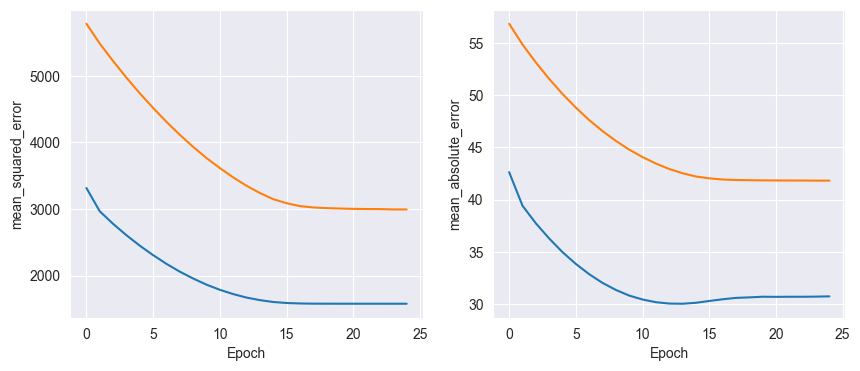

255/255 [==============================] - 5s 18ms/step - loss: 1861.8326 - mean_absolute_error: 32.9533
units: 50, dropout: 0.2, batch size: 32, optimizer: SGD, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 15s 55ms/step - loss: 1802.2604 - mean_absolute_error: 32.6338 - val_loss: 2721.3738 - val_mean_absolute_error: 37.7267
Epoch 2/100
229/229 [==============================] - 14s 59ms/step - loss: 894.2540 - mean_absolute_error: 20.8194 - val_loss: 1048.1123 - val_mean_absolute_error: 22.6599
Epoch 3/100
229/229 [==============================] - 13s 58ms/step - loss: 691.6407 - mean_absolute_error: 17.9956 - val_loss: 796.9890 - val_mean_absolute_error: 19.9929
Epoch 4/100
229/229 [==============================] - 13s 59ms/step - loss: 662.6328 - mean_absolute_error: 17.4520 - val_loss: 786.1455 - val_mean_absolute_error: 19.4624
Epoch 5/100
229/229 [==============================] - 13s 58ms/step - loss: 628.3765 - mean_absolute_error: 16.9858 - va

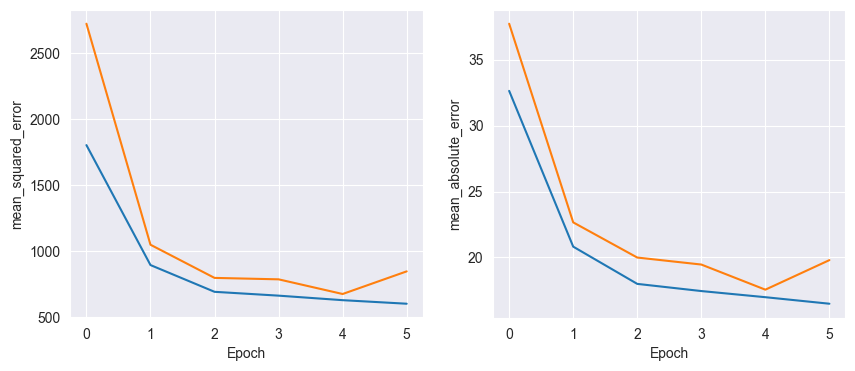

255/255 [==============================] - 5s 20ms/step - loss: 614.0994 - mean_absolute_error: 15.6931
units: 50, dropout: 0.2, batch size: 32, optimizer: SGD, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 14s 57ms/step - loss: 1677.6234 - mean_absolute_error: 31.3922 - val_loss: 3222.9397 - val_mean_absolute_error: 42.4326
Epoch 2/100
204/204 [==============================] - 13s 65ms/step - loss: 1621.9255 - mean_absolute_error: 30.9887 - val_loss: 2818.9492 - val_mean_absolute_error: 41.6226
Epoch 3/100
204/204 [==============================] - 14s 66ms/step - loss: 1578.0846 - mean_absolute_error: 30.5816 - val_loss: 3059.7146 - val_mean_absolute_error: 41.9309


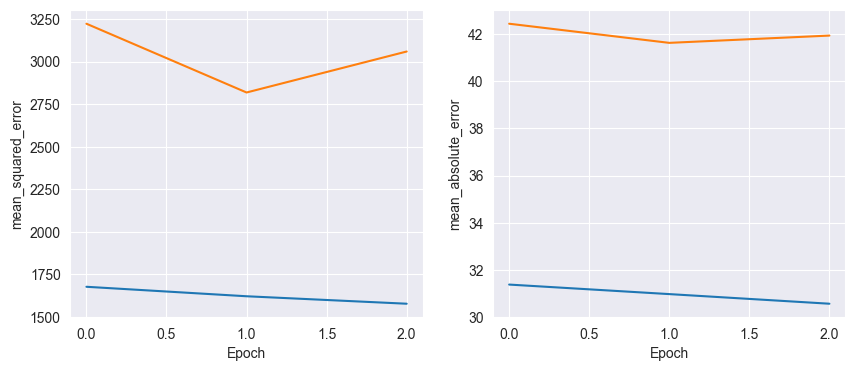

255/255 [==============================] - 5s 20ms/step - loss: 1873.8469 - mean_absolute_error: 32.6874
units: 50, dropout: 0.2, batch size: 64, optimizer: SGD, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 14s 93ms/step - loss: 1842.5532 - mean_absolute_error: 32.9963 - val_loss: 2709.1833 - val_mean_absolute_error: 42.4147
Epoch 2/100
115/115 [==============================] - 12s 102ms/step - loss: 1760.9431 - mean_absolute_error: 32.3681 - val_loss: 2724.6704 - val_mean_absolute_error: 43.8401


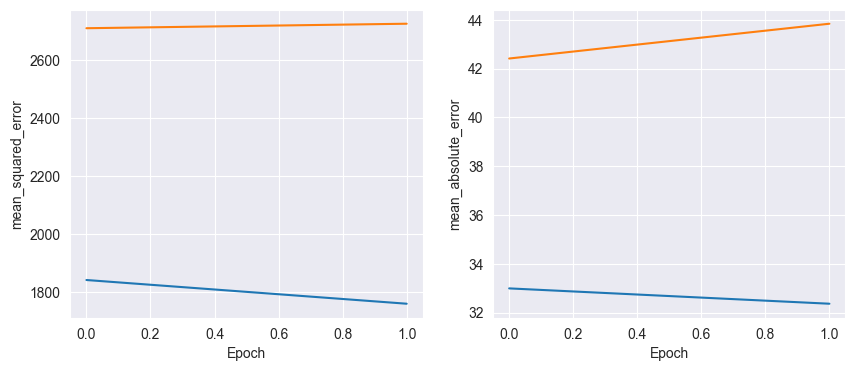

255/255 [==============================] - 5s 21ms/step - loss: 2099.5518 - mean_absolute_error: 38.3856
units: 50, dropout: 0.2, batch size: 64, optimizer: SGD, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 14s 105ms/step - loss: 1654.6204 - mean_absolute_error: 31.1074 - val_loss: 2401.7615 - val_mean_absolute_error: 41.9309
Epoch 2/100
102/102 [==============================] - 10s 99ms/step - loss: 1030.8466 - mean_absolute_error: 23.1979 - val_loss: 1094.8225 - val_mean_absolute_error: 25.2740
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 659.4406 - mean_absolute_error: 17.6160 - val_loss: 1339.0752 - val_mean_absolute_error: 27.1268


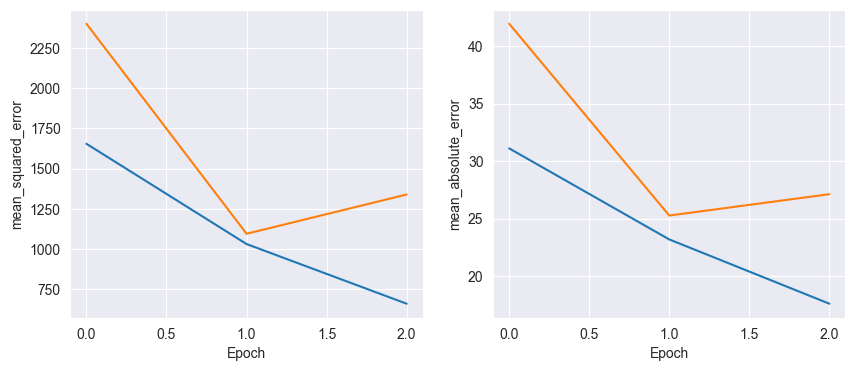

255/255 [==============================] - 5s 20ms/step - loss: 1346.5161 - mean_absolute_error: 27.4906
units: 50, dropout: 0.2, batch size: 128, optimizer: SGD, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 11s 143ms/step - loss: 1889.6702 - mean_absolute_error: 33.2110 - val_loss: 2797.6584 - val_mean_absolute_error: 41.6000
Epoch 2/100
58/58 [==============================] - 9s 151ms/step - loss: 1770.5551 - mean_absolute_error: 32.5201 - val_loss: 3588.6892 - val_mean_absolute_error: 43.3595


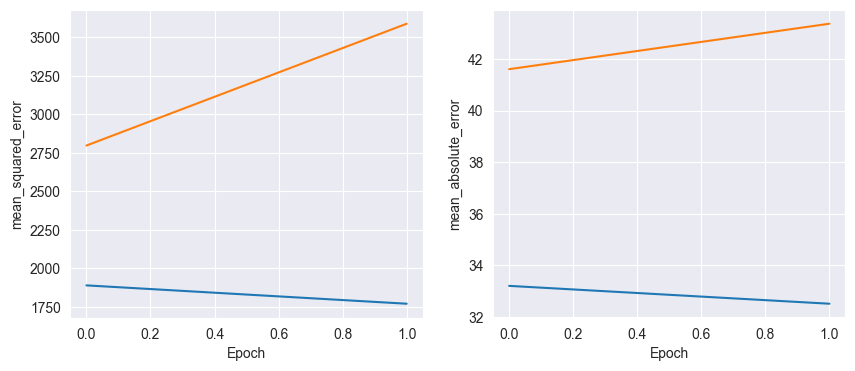

255/255 [==============================] - 5s 19ms/step - loss: 2194.1880 - mean_absolute_error: 33.3289
units: 50, dropout: 0.2, batch size: 128, optimizer: SGD, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 11s 155ms/step - loss: 1722.9663 - mean_absolute_error: 31.7156 - val_loss: 2941.0488 - val_mean_absolute_error: 41.0567
Epoch 2/100
51/51 [==============================] - 7s 143ms/step - loss: 1622.1868 - mean_absolute_error: 31.1100 - val_loss: 3273.8440 - val_mean_absolute_error: 42.6343


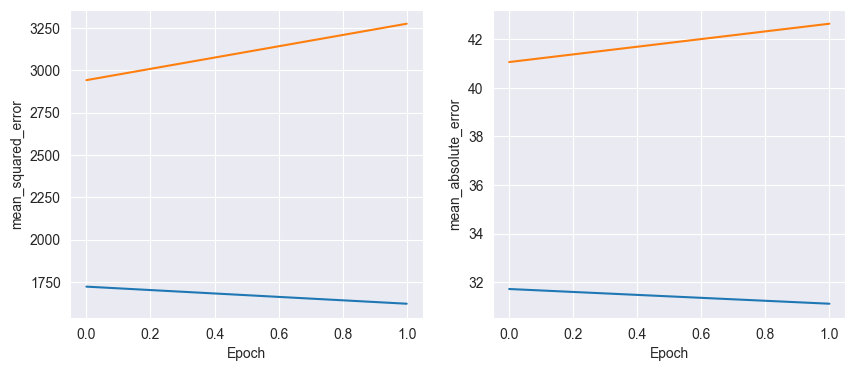

255/255 [==============================] - 6s 25ms/step - loss: 1954.3431 - mean_absolute_error: 32.5427
units: 50, dropout: 0.2, batch size: 32, optimizer: Adam, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 19s 69ms/step - loss: 3256.0508 - mean_absolute_error: 41.2186 - val_loss: 4700.0186 - val_mean_absolute_error: 49.2073
Epoch 2/100
229/229 [==============================] - 16s 69ms/step - loss: 2509.9458 - mean_absolute_error: 35.2736 - val_loss: 3957.2878 - val_mean_absolute_error: 45.0374
Epoch 3/100
229/229 [==============================] - 16s 69ms/step - loss: 2117.6902 - mean_absolute_error: 32.7082 - val_loss: 3490.6646 - val_mean_absolute_error: 42.9858
Epoch 4/100
229/229 [==============================] - 16s 72ms/step - loss: 1910.3339 - mean_absolute_error: 31.7544 - val_loss: 3205.1418 - val_mean_absolute_error: 42.0242
Epoch 5/100
229/229 [==============================] - 16s 68ms/step - loss: 1815.2311 - mean_absolute_error: 31.65

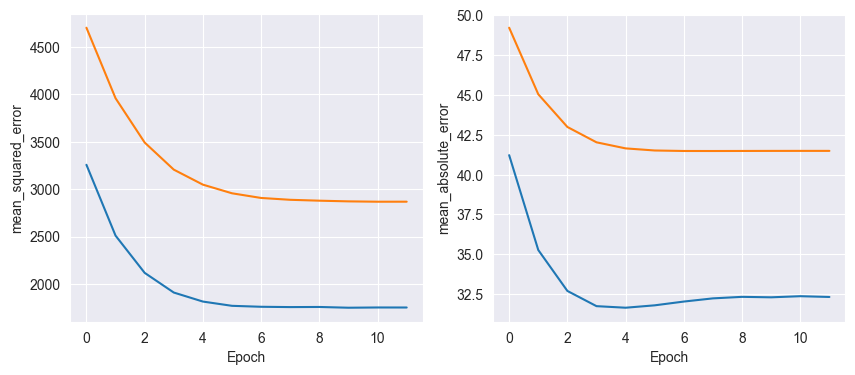

255/255 [==============================] - 6s 23ms/step - loss: 1853.7094 - mean_absolute_error: 33.1863
units: 50, dropout: 0.2, batch size: 32, optimizer: Adam, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 18s 72ms/step - loss: 2959.9341 - mean_absolute_error: 39.5050 - val_loss: 4952.4131 - val_mean_absolute_error: 51.4496
Epoch 2/100
204/204 [==============================] - 14s 69ms/step - loss: 2264.6785 - mean_absolute_error: 33.5555 - val_loss: 4206.4644 - val_mean_absolute_error: 47.0627
Epoch 3/100
204/204 [==============================] - 15s 72ms/step - loss: 1929.2596 - mean_absolute_error: 31.2807 - val_loss: 3733.8523 - val_mean_absolute_error: 44.6430
Epoch 4/100
204/204 [==============================] - 14s 70ms/step - loss: 1742.7626 - mean_absolute_error: 30.3124 - val_loss: 3426.3867 - val_mean_absolute_error: 43.2505
Epoch 5/100
204/204 [==============================] - 15s 72ms/step - loss: 1654.0741 - mean_absolute_error: 30.14

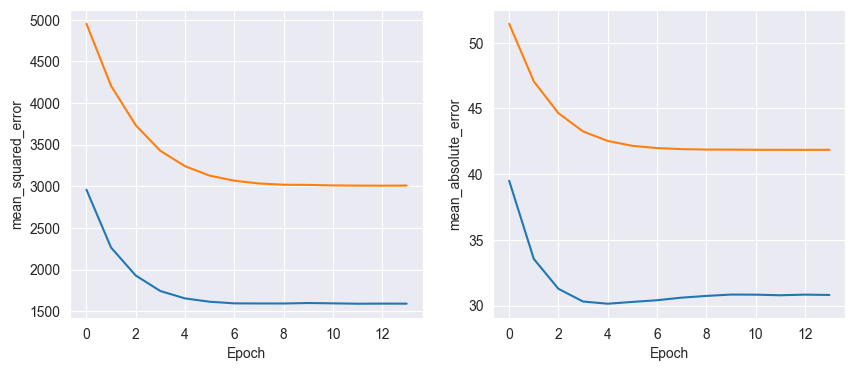

255/255 [==============================] - 5s 21ms/step - loss: 1864.9586 - mean_absolute_error: 32.9031
units: 50, dropout: 0.2, batch size: 64, optimizer: Adam, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 16s 108ms/step - loss: 3553.8030 - mean_absolute_error: 43.8039 - val_loss: 5194.2476 - val_mean_absolute_error: 52.3945
Epoch 2/100
115/115 [==============================] - 12s 107ms/step - loss: 2938.3472 - mean_absolute_error: 38.5543 - val_loss: 4654.8076 - val_mean_absolute_error: 48.9295
Epoch 3/100
115/115 [==============================] - 12s 106ms/step - loss: 2598.9883 - mean_absolute_error: 35.8908 - val_loss: 4236.7104 - val_mean_absolute_error: 46.4946
Epoch 4/100
115/115 [==============================] - 11s 100ms/step - loss: 2347.9341 - mean_absolute_error: 34.1109 - val_loss: 3906.3826 - val_mean_absolute_error: 44.7928
Epoch 5/100
115/115 [==============================] - 12s 103ms/step - loss: 2154.8484 - mean_absolute_error: 

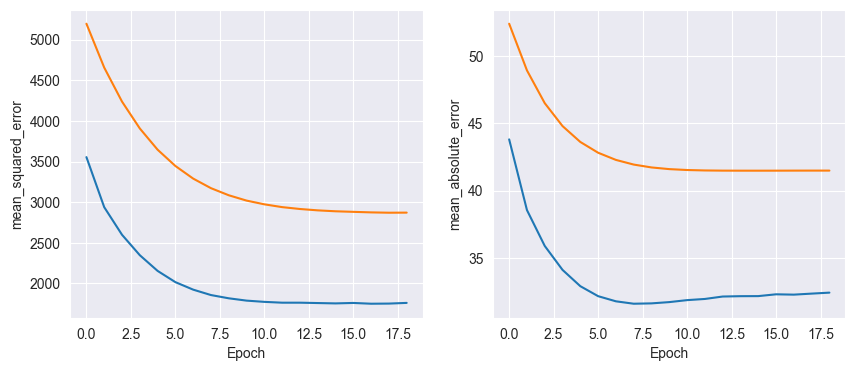

255/255 [==============================] - 5s 18ms/step - loss: 1854.2147 - mean_absolute_error: 33.1630
units: 50, dropout: 0.2, batch size: 64, optimizer: Adam, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 13s 93ms/step - loss: 3163.6770 - mean_absolute_error: 41.3050 - val_loss: 5389.3066 - val_mean_absolute_error: 54.2451
Epoch 2/100
102/102 [==============================] - 9s 90ms/step - loss: 2631.4270 - mean_absolute_error: 36.4673 - val_loss: 4886.8853 - val_mean_absolute_error: 51.0405
Epoch 3/100
102/102 [==============================] - 9s 88ms/step - loss: 2345.4395 - mean_absolute_error: 34.1664 - val_loss: 4489.3369 - val_mean_absolute_error: 48.6558
Epoch 4/100
102/102 [==============================] - 9s 89ms/step - loss: 2127.9646 - mean_absolute_error: 32.5308 - val_loss: 4164.9629 - val_mean_absolute_error: 46.8406
Epoch 5/100
102/102 [==============================] - 9s 89ms/step - loss: 1968.6168 - mean_absolute_error: 31.4550 -

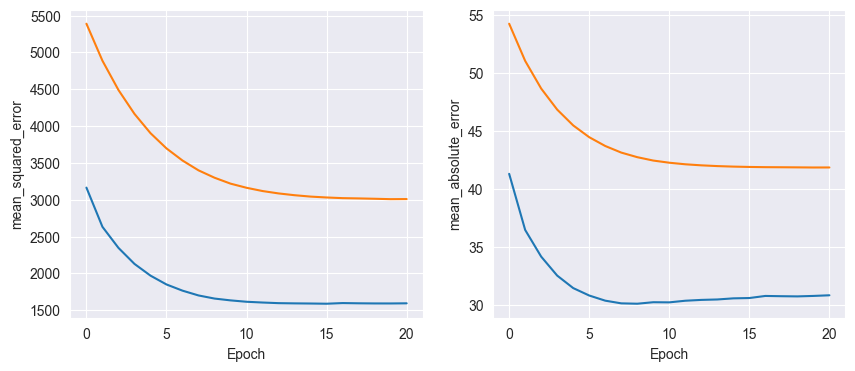

255/255 [==============================] - 5s 21ms/step - loss: 1864.7423 - mean_absolute_error: 32.9063
units: 50, dropout: 0.2, batch size: 128, optimizer: Adam, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 11s 136ms/step - loss: 3851.2939 - mean_absolute_error: 46.5089 - val_loss: 5588.9551 - val_mean_absolute_error: 55.0971
Epoch 2/100
58/58 [==============================] - 8s 138ms/step - loss: 3298.9365 - mean_absolute_error: 41.5826 - val_loss: 5222.7886 - val_mean_absolute_error: 52.5851
Epoch 3/100
58/58 [==============================] - 8s 135ms/step - loss: 3058.8945 - mean_absolute_error: 39.5400 - val_loss: 4932.1377 - val_mean_absolute_error: 50.6724
Epoch 4/100
58/58 [==============================] - 8s 134ms/step - loss: 2859.9802 - mean_absolute_error: 37.9214 - val_loss: 4679.9146 - val_mean_absolute_error: 49.0815
Epoch 5/100
58/58 [==============================] - 8s 134ms/step - loss: 2685.0261 - mean_absolute_error: 36.5326 - val

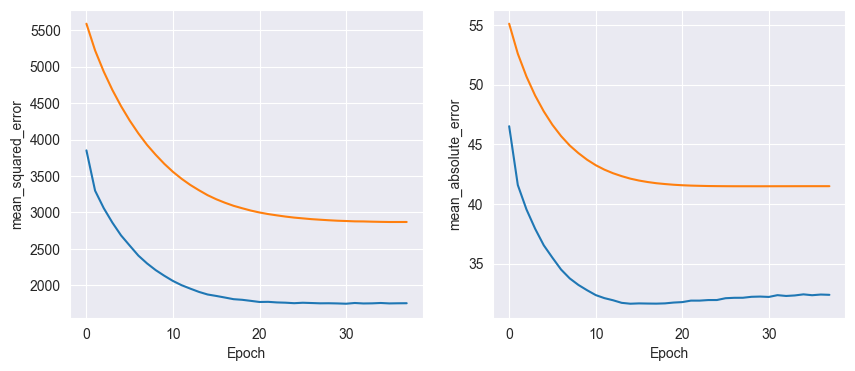

255/255 [==============================] - 5s 19ms/step - loss: 1853.9519 - mean_absolute_error: 33.1750
units: 50, dropout: 0.2, batch size: 128, optimizer: Adam, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 10s 143ms/step - loss: 3602.7949 - mean_absolute_error: 45.3486 - val_loss: 6016.1987 - val_mean_absolute_error: 58.4592
Epoch 2/100
51/51 [==============================] - 7s 132ms/step - loss: 3096.6682 - mean_absolute_error: 40.5996 - val_loss: 5641.8960 - val_mean_absolute_error: 55.9197
Epoch 3/100
51/51 [==============================] - 7s 132ms/step - loss: 2874.9822 - mean_absolute_error: 38.5954 - val_loss: 5353.1313 - val_mean_absolute_error: 54.0099
Epoch 4/100
51/51 [==============================] - 7s 133ms/step - loss: 2693.2688 - mean_absolute_error: 37.0086 - val_loss: 5099.6714 - val_mean_absolute_error: 52.3765
Epoch 5/100
51/51 [==============================] - 7s 133ms/step - loss: 2532.1936 - mean_absolute_error: 35.6762 - val

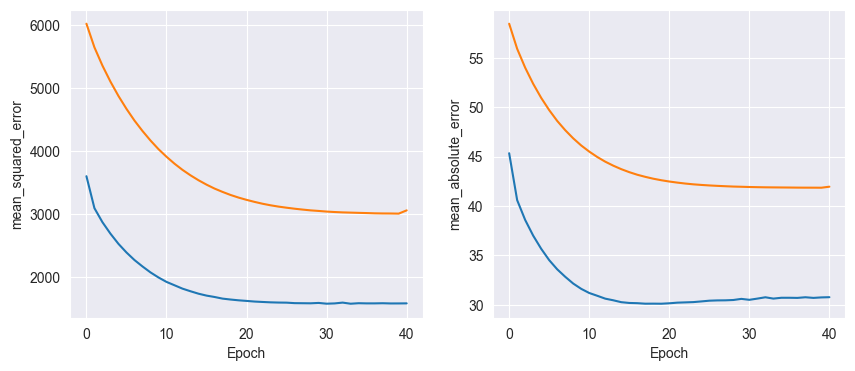

255/255 [==============================] - 5s 18ms/step - loss: 1873.8628 - mean_absolute_error: 32.6942
units: 50, dropout: 0.2, batch size: 32, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 15s 55ms/step - loss: 3265.1682 - mean_absolute_error: 41.3016 - val_loss: 4736.2529 - val_mean_absolute_error: 49.4325
Epoch 2/100
229/229 [==============================] - 14s 60ms/step - loss: 2493.6350 - mean_absolute_error: 35.1221 - val_loss: 3871.1079 - val_mean_absolute_error: 44.6257
Epoch 3/100
229/229 [==============================] - 13s 59ms/step - loss: 2037.5958 - mean_absolute_error: 32.3465 - val_loss: 3288.1040 - val_mean_absolute_error: 42.2748
Epoch 4/100
229/229 [==============================] - 14s 60ms/step - loss: 1815.2689 - mean_absolute_error: 31.6806 - val_loss: 2987.9460 - val_mean_absolute_error: 41.5491
Epoch 5/100
229/229 [==============================] - 14s 60ms/step - loss: 1763.6937 - mean_absolute_error: 32

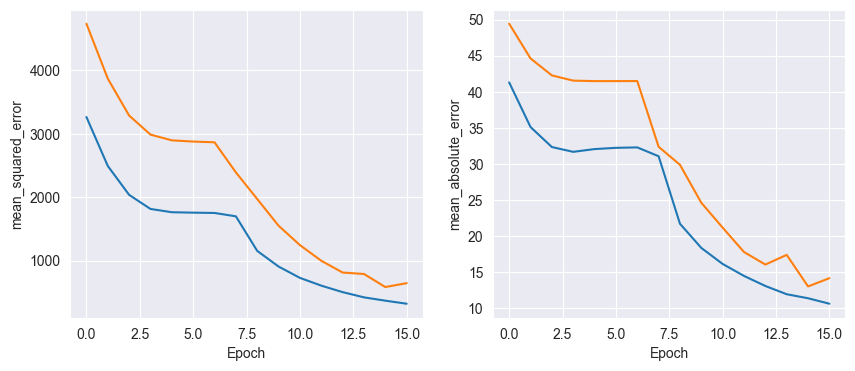

255/255 [==============================] - 5s 21ms/step - loss: 338.7523 - mean_absolute_error: 9.5560
units: 50, dropout: 0.2, batch size: 32, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 2948.6704 - mean_absolute_error: 39.2886 - val_loss: 5019.9907 - val_mean_absolute_error: 51.8733
Epoch 2/100
204/204 [==============================] - 13s 63ms/step - loss: 2278.4324 - mean_absolute_error: 33.6820 - val_loss: 4169.9365 - val_mean_absolute_error: 46.8674
Epoch 3/100
204/204 [==============================] - 14s 67ms/step - loss: 1873.6426 - mean_absolute_error: 30.9140 - val_loss: 3566.4414 - val_mean_absolute_error: 43.8622
Epoch 4/100
204/204 [==============================] - 15s 71ms/step - loss: 1658.7090 - mean_absolute_error: 30.1149 - val_loss: 3197.6255 - val_mean_absolute_error: 42.3801
Epoch 5/100
204/204 [==============================] - 14s 70ms/step - loss: 1599.8710 - mean_absolute_error: 30.3

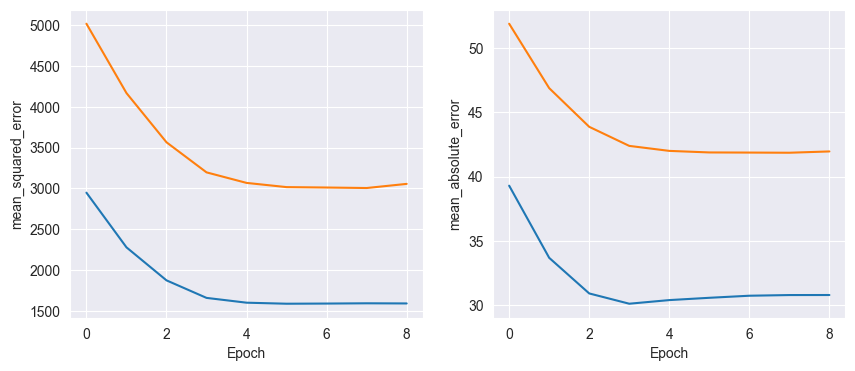

255/255 [==============================] - 6s 22ms/step - loss: 1875.3746 - mean_absolute_error: 32.7448
units: 50, dropout: 0.2, batch size: 64, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 14s 102ms/step - loss: 3440.4529 - mean_absolute_error: 42.8382 - val_loss: 5195.7720 - val_mean_absolute_error: 52.4047
Epoch 2/100
115/115 [==============================] - 12s 101ms/step - loss: 2943.5432 - mean_absolute_error: 38.5866 - val_loss: 4659.2637 - val_mean_absolute_error: 48.9565
Epoch 3/100
115/115 [==============================] - 11s 99ms/step - loss: 2583.5190 - mean_absolute_error: 35.7667 - val_loss: 4192.6147 - val_mean_absolute_error: 46.2534
Epoch 4/100
115/115 [==============================] - 12s 104ms/step - loss: 2292.6816 - mean_absolute_error: 33.7595 - val_loss: 3792.5464 - val_mean_absolute_error: 44.2626
Epoch 5/100
115/115 [==============================] - 11s 99ms/step - loss: 2068.4565 - mean_absolute_error:

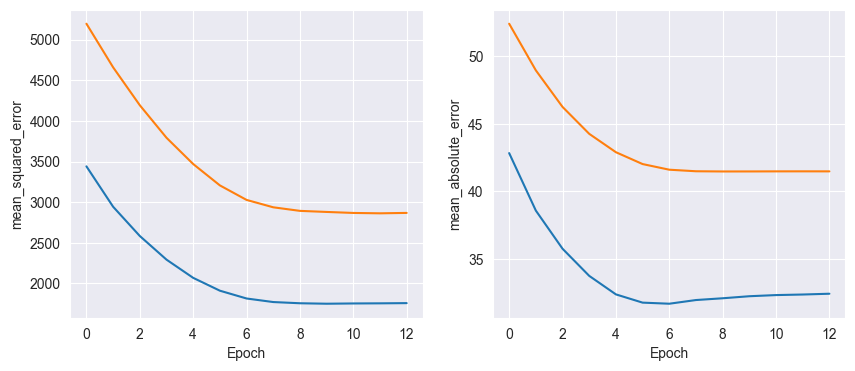

255/255 [==============================] - 5s 19ms/step - loss: 1853.7474 - mean_absolute_error: 33.1845
units: 50, dropout: 0.2, batch size: 64, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 14s 108ms/step - loss: 3110.5471 - mean_absolute_error: 40.7448 - val_loss: 5448.1006 - val_mean_absolute_error: 54.6328
Epoch 2/100
102/102 [==============================] - 10s 99ms/step - loss: 2675.1814 - mean_absolute_error: 36.8641 - val_loss: 4944.1597 - val_mean_absolute_error: 51.3983
Epoch 3/100
102/102 [==============================] - 10s 99ms/step - loss: 2362.9016 - mean_absolute_error: 34.2790 - val_loss: 4497.6226 - val_mean_absolute_error: 48.7039
Epoch 4/100
102/102 [==============================] - 11s 106ms/step - loss: 2114.9021 - mean_absolute_error: 32.4178 - val_loss: 4105.0078 - val_mean_absolute_error: 46.5209
Epoch 5/100
102/102 [==============================] - 10s 100ms/step - loss: 1915.1064 - mean_absolute_error:

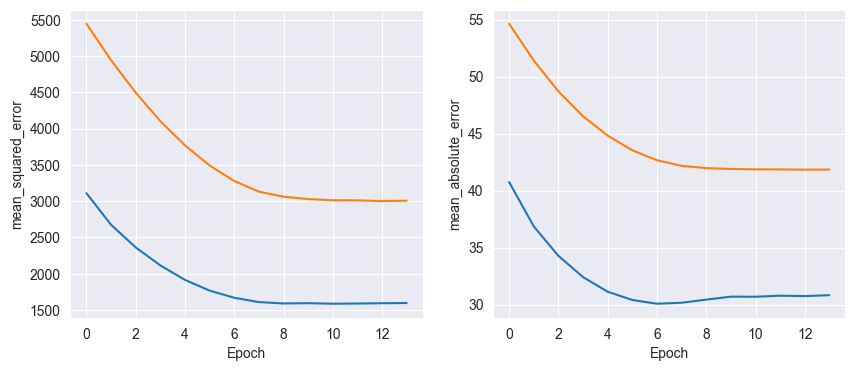

255/255 [==============================] - 5s 21ms/step - loss: 1864.5671 - mean_absolute_error: 32.9090
units: 50, dropout: 0.2, batch size: 128, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 14s 149ms/step - loss: 3661.2876 - mean_absolute_error: 44.7663 - val_loss: 5558.0640 - val_mean_absolute_error: 54.8795
Epoch 2/100
58/58 [==============================] - 9s 149ms/step - loss: 3304.9797 - mean_absolute_error: 41.6106 - val_loss: 5249.5435 - val_mean_absolute_error: 52.7631
Epoch 3/100
58/58 [==============================] - 9s 148ms/step - loss: 3083.6943 - mean_absolute_error: 39.7426 - val_loss: 4964.0796 - val_mean_absolute_error: 50.8776
Epoch 4/100
58/58 [==============================] - 9s 154ms/step - loss: 2877.1196 - mean_absolute_error: 38.0624 - val_loss: 4695.6538 - val_mean_absolute_error: 49.1801
Epoch 5/100
58/58 [==============================] - 9s 151ms/step - loss: 2691.4221 - mean_absolute_error: 36.5743 - 

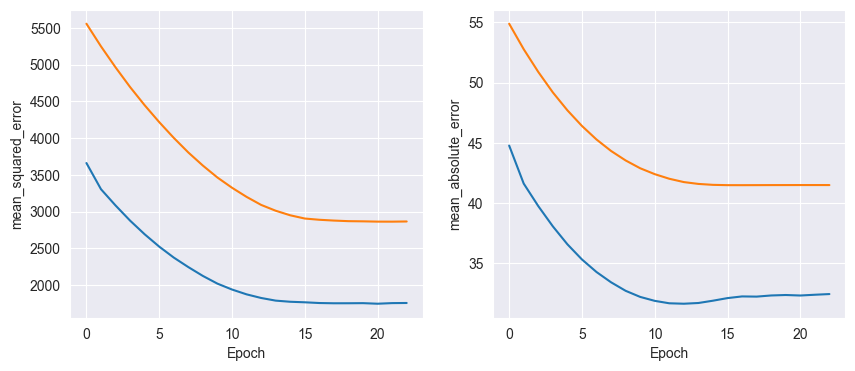

255/255 [==============================] - 5s 21ms/step - loss: 1853.5249 - mean_absolute_error: 33.1954
units: 50, dropout: 0.2, batch size: 128, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 11s 160ms/step - loss: 3315.6431 - mean_absolute_error: 42.6367 - val_loss: 5799.3975 - val_mean_absolute_error: 56.9788
Epoch 2/100
51/51 [==============================] - 8s 148ms/step - loss: 2982.1316 - mean_absolute_error: 39.5684 - val_loss: 5504.3945 - val_mean_absolute_error: 55.0035
Epoch 3/100
51/51 [==============================] - 7s 147ms/step - loss: 2793.6553 - mean_absolute_error: 37.8761 - val_loss: 5240.0430 - val_mean_absolute_error: 53.2763
Epoch 4/100
51/51 [==============================] - 8s 156ms/step - loss: 2620.6599 - mean_absolute_error: 36.3920 - val_loss: 4990.7070 - val_mean_absolute_error: 51.6876
Epoch 5/100
51/51 [==============================] - 7s 146ms/step - loss: 2468.4590 - mean_absolute_error: 35.1259 - 

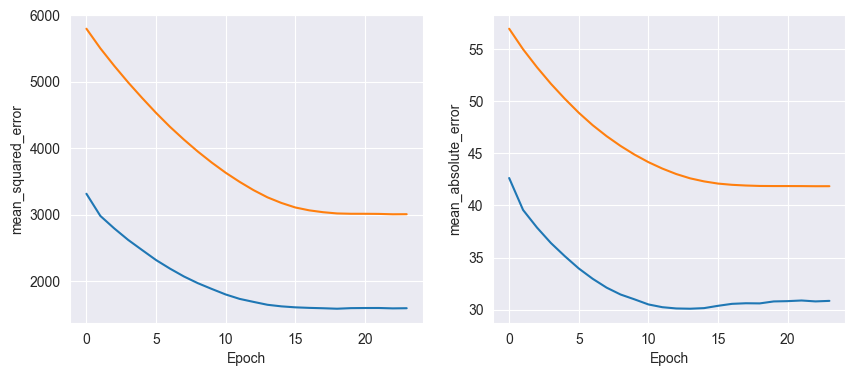

255/255 [==============================] - 5s 20ms/step - loss: 1864.7111 - mean_absolute_error: 32.9068
units: 100, dropout: 0, batch size: 32, optimizer: SGD, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 29s 117ms/step - loss: 1852.7611 - mean_absolute_error: 33.3332 - val_loss: 3772.0635 - val_mean_absolute_error: 44.1567
Epoch 2/100
229/229 [==============================] - 27s 116ms/step - loss: 1803.0524 - mean_absolute_error: 32.8924 - val_loss: 2709.7026 - val_mean_absolute_error: 43.3517
Epoch 3/100
229/229 [==============================] - 26s 115ms/step - loss: 1794.5554 - mean_absolute_error: 32.8163 - val_loss: 3154.1187 - val_mean_absolute_error: 41.7228


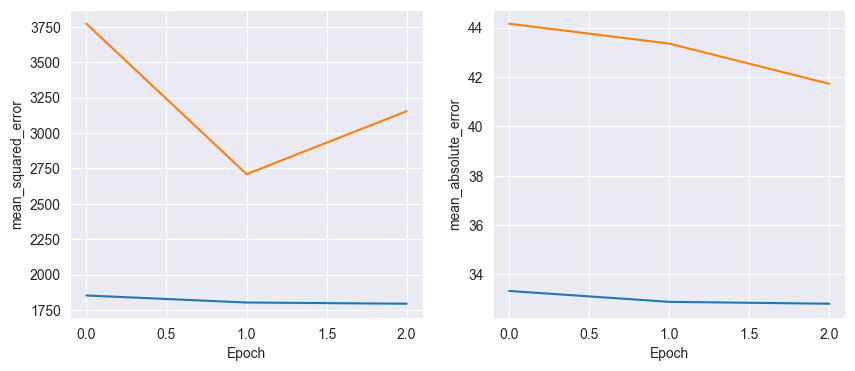

255/255 [==============================] - 10s 41ms/step - loss: 1944.3358 - mean_absolute_error: 32.3558
units: 100, dropout: 0, batch size: 32, optimizer: SGD, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 27s 119ms/step - loss: 1660.8247 - mean_absolute_error: 31.3948 - val_loss: 3642.5989 - val_mean_absolute_error: 44.2016
Epoch 2/100
204/204 [==============================] - 24s 120ms/step - loss: 1200.4999 - mean_absolute_error: 25.3702 - val_loss: 1817.7001 - val_mean_absolute_error: 30.7686
Epoch 3/100
204/204 [==============================] - 25s 120ms/step - loss: 609.9327 - mean_absolute_error: 16.6676 - val_loss: 1670.2999 - val_mean_absolute_error: 28.7513
Epoch 4/100
204/204 [==============================] - 25s 123ms/step - loss: 579.4493 - mean_absolute_error: 16.2210 - val_loss: 1284.9570 - val_mean_absolute_error: 25.4926
Epoch 5/100
204/204 [==============================] - 25s 121ms/step - loss: 557.7622 - mean_absolute_error: 15.8

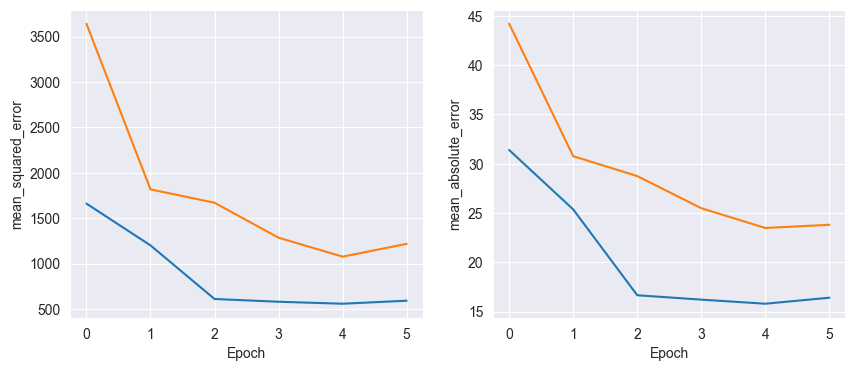

255/255 [==============================] - 11s 43ms/step - loss: 645.1428 - mean_absolute_error: 15.8751
units: 100, dropout: 0, batch size: 64, optimizer: SGD, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 21s 163ms/step - loss: 1854.7174 - mean_absolute_error: 33.1828 - val_loss: 2733.4026 - val_mean_absolute_error: 44.6900
Epoch 2/100
115/115 [==============================] - 19s 163ms/step - loss: 1398.9506 - mean_absolute_error: 27.6783 - val_loss: 879.5762 - val_mean_absolute_error: 21.2847
Epoch 3/100
115/115 [==============================] - 18s 160ms/step - loss: 722.1947 - mean_absolute_error: 18.7129 - val_loss: 1154.1747 - val_mean_absolute_error: 22.9627


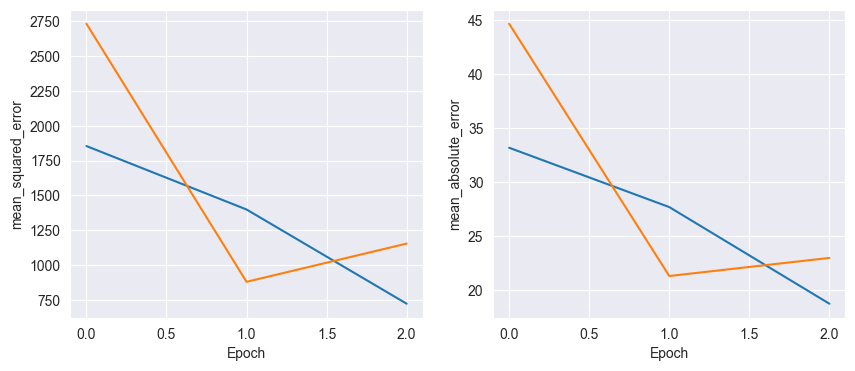

255/255 [==============================] - 10s 40ms/step - loss: 708.2502 - mean_absolute_error: 16.3933
units: 100, dropout: 0, batch size: 64, optimizer: SGD, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 20s 172ms/step - loss: 1642.1589 - mean_absolute_error: 31.1041 - val_loss: 2726.0637 - val_mean_absolute_error: 41.8031
Epoch 2/100
102/102 [==============================] - 17s 171ms/step - loss: 1585.8052 - mean_absolute_error: 30.6848 - val_loss: 3359.8718 - val_mean_absolute_error: 42.4378


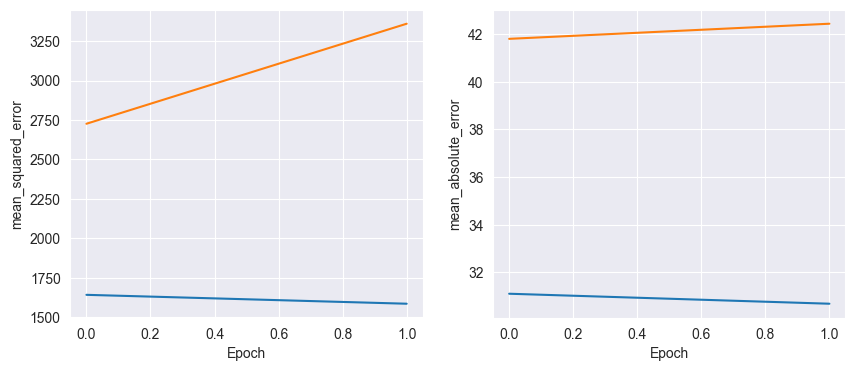

255/255 [==============================] - 11s 42ms/step - loss: 1908.8252 - mean_absolute_error: 30.9258
units: 100, dropout: 0, batch size: 128, optimizer: SGD, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 18s 269ms/step - loss: 1877.8344 - mean_absolute_error: 33.3031 - val_loss: 2718.5298 - val_mean_absolute_error: 41.8484
Epoch 2/100
58/58 [==============================] - 15s 258ms/step - loss: 1769.0413 - mean_absolute_error: 32.5054 - val_loss: 2687.2654 - val_mean_absolute_error: 43.1073
Epoch 3/100
58/58 [==============================] - 15s 258ms/step - loss: 1730.3250 - mean_absolute_error: 31.8541 - val_loss: 2832.6016 - val_mean_absolute_error: 40.5916


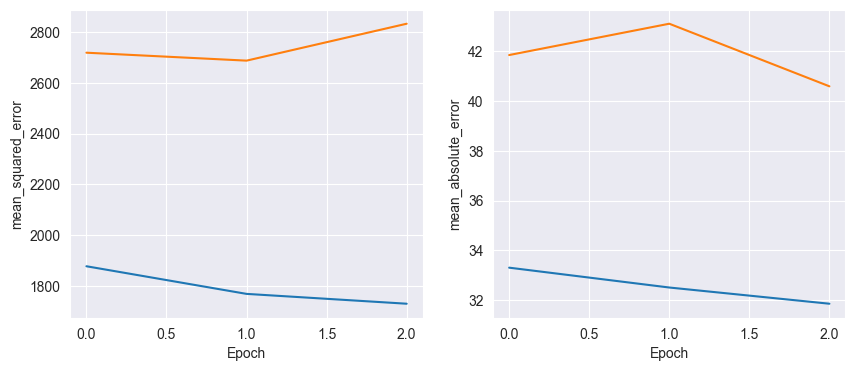

255/255 [==============================] - 11s 42ms/step - loss: 1789.1337 - mean_absolute_error: 31.9384
units: 100, dropout: 0, batch size: 128, optimizer: SGD, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 18s 292ms/step - loss: 1706.8625 - mean_absolute_error: 31.6024 - val_loss: 2953.9500 - val_mean_absolute_error: 41.6475
Epoch 2/100
51/51 [==============================] - 14s 283ms/step - loss: 1606.0518 - mean_absolute_error: 30.7182 - val_loss: 3292.1777 - val_mean_absolute_error: 42.3409


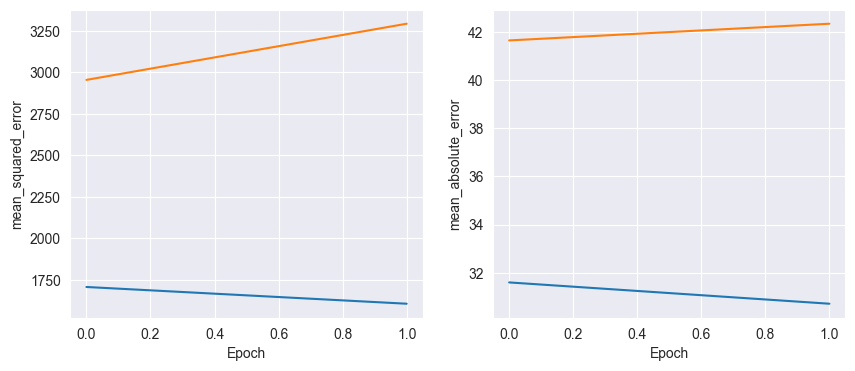

255/255 [==============================] - 10s 41ms/step - loss: 1938.1560 - mean_absolute_error: 31.9445
units: 100, dropout: 0, batch size: 32, optimizer: Adam, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 30s 118ms/step - loss: 2681.4929 - mean_absolute_error: 36.7183 - val_loss: 3724.1523 - val_mean_absolute_error: 43.9555
Epoch 2/100
229/229 [==============================] - 26s 115ms/step - loss: 1918.6436 - mean_absolute_error: 31.8107 - val_loss: 3102.3567 - val_mean_absolute_error: 41.7610
Epoch 3/100
229/229 [==============================] - 28s 120ms/step - loss: 1764.8213 - mean_absolute_error: 31.7797 - val_loss: 2924.4358 - val_mean_absolute_error: 41.4882
Epoch 4/100
229/229 [==============================] - 27s 117ms/step - loss: 1743.2616 - mean_absolute_error: 32.1200 - val_loss: 2880.6443 - val_mean_absolute_error: 41.4812
Epoch 5/100
229/229 [==============================] - 26s 115ms/step - loss: 1741.4091 - mean_absolute_error: 

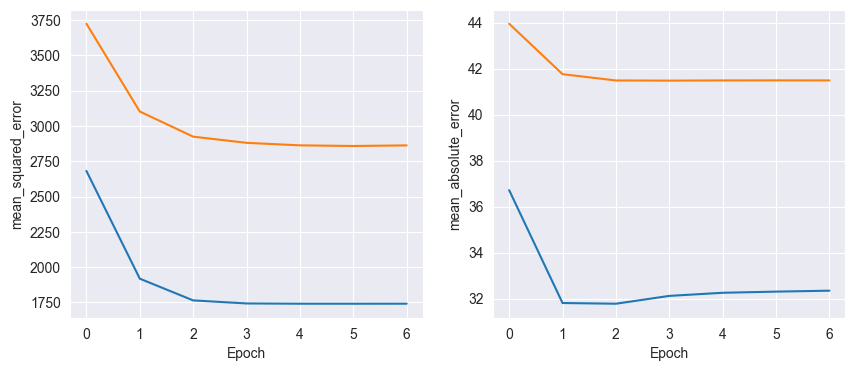

255/255 [==============================] - 11s 42ms/step - loss: 1853.1656 - mean_absolute_error: 33.2142
units: 100, dropout: 0, batch size: 32, optimizer: Adam, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 29s 127ms/step - loss: 2536.9473 - mean_absolute_error: 35.8976 - val_loss: 4092.0295 - val_mean_absolute_error: 46.4526
Epoch 2/100
204/204 [==============================] - 26s 126ms/step - loss: 1782.5490 - mean_absolute_error: 30.4800 - val_loss: 3356.4280 - val_mean_absolute_error: 42.9666
Epoch 3/100
204/204 [==============================] - 26s 126ms/step - loss: 1610.6110 - mean_absolute_error: 30.1496 - val_loss: 3103.3127 - val_mean_absolute_error: 42.0854
Epoch 4/100
204/204 [==============================] - 26s 128ms/step - loss: 1582.0751 - mean_absolute_error: 30.4506 - val_loss: 3020.2805 - val_mean_absolute_error: 41.8777
Epoch 5/100
204/204 [==============================] - 26s 127ms/step - loss: 1578.7670 - mean_absolute_error: 

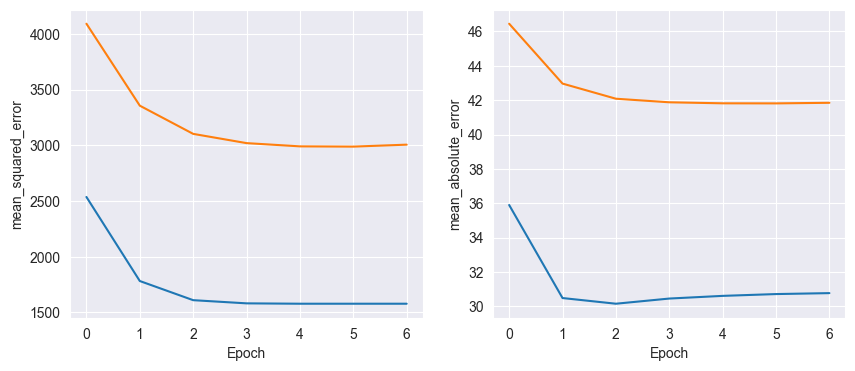

255/255 [==============================] - 11s 43ms/step - loss: 1864.2960 - mean_absolute_error: 32.9103
units: 100, dropout: 0, batch size: 64, optimizer: Adam, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 23s 172ms/step - loss: 3042.8618 - mean_absolute_error: 39.5134 - val_loss: 4376.6548 - val_mean_absolute_error: 47.2801
Epoch 2/100
115/115 [==============================] - 20s 171ms/step - loss: 2308.6550 - mean_absolute_error: 33.8326 - val_loss: 3705.6621 - val_mean_absolute_error: 43.8733
Epoch 3/100
115/115 [==============================] - 19s 169ms/step - loss: 1985.8639 - mean_absolute_error: 31.9881 - val_loss: 3309.7615 - val_mean_absolute_error: 42.3438
Epoch 4/100
115/115 [==============================] - 20s 177ms/step - loss: 1833.2607 - mean_absolute_error: 31.5581 - val_loss: 3090.1218 - val_mean_absolute_error: 41.7329
Epoch 5/100
115/115 [==============================] - 20s 178ms/step - loss: 1771.2980 - mean_absolute_error: 

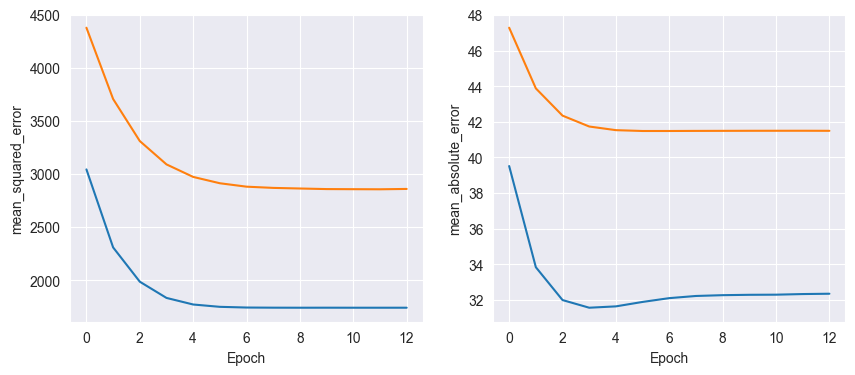

255/255 [==============================] - 11s 43ms/step - loss: 1852.8069 - mean_absolute_error: 33.2351
units: 100, dropout: 0, batch size: 64, optimizer: Adam, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 22s 181ms/step - loss: 2869.1433 - mean_absolute_error: 38.6495 - val_loss: 4809.5435 - val_mean_absolute_error: 50.5651
Epoch 2/100
102/102 [==============================] - 19s 189ms/step - loss: 2194.2852 - mean_absolute_error: 33.0090 - val_loss: 4113.9512 - val_mean_absolute_error: 46.5678
Epoch 3/100
102/102 [==============================] - 19s 186ms/step - loss: 1879.0913 - mean_absolute_error: 30.9263 - val_loss: 3664.5520 - val_mean_absolute_error: 44.3131
Epoch 4/100
102/102 [==============================] - 19s 188ms/step - loss: 1711.3441 - mean_absolute_error: 30.1359 - val_loss: 3383.8037 - val_mean_absolute_error: 43.0762
Epoch 5/100
102/102 [==============================] - 19s 189ms/step - loss: 1630.6991 - mean_absolute_error: 

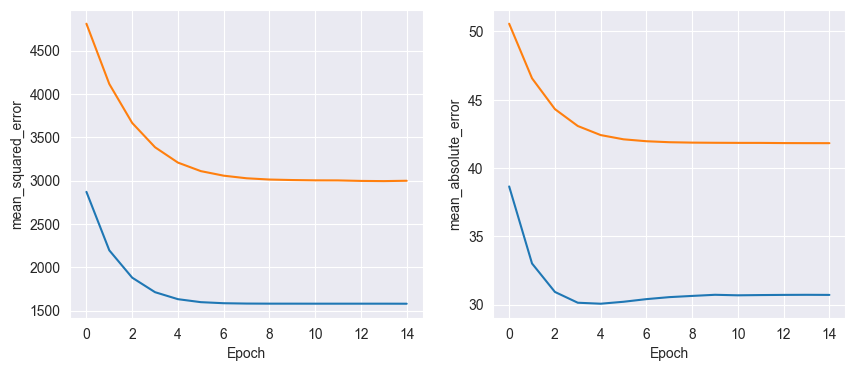

255/255 [==============================] - 10s 41ms/step - loss: 1861.5315 - mean_absolute_error: 32.9230
units: 100, dropout: 0, batch size: 128, optimizer: Adam, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 24s 333ms/step - loss: 3399.5269 - mean_absolute_error: 42.4975 - val_loss: 4927.0874 - val_mean_absolute_error: 50.6402
Epoch 2/100
58/58 [==============================] - 19s 321ms/step - loss: 2751.4834 - mean_absolute_error: 37.0148 - val_loss: 4401.6738 - val_mean_absolute_error: 47.4232
Epoch 3/100
58/58 [==============================] - 18s 312ms/step - loss: 2429.1882 - mean_absolute_error: 34.6532 - val_loss: 4006.0198 - val_mean_absolute_error: 45.2811
Epoch 4/100
58/58 [==============================] - 18s 312ms/step - loss: 2199.9958 - mean_absolute_error: 33.1365 - val_loss: 3701.1936 - val_mean_absolute_error: 43.8533
Epoch 5/100
58/58 [==============================] - 19s 320ms/step - loss: 2038.1592 - mean_absolute_error: 32.2495 -

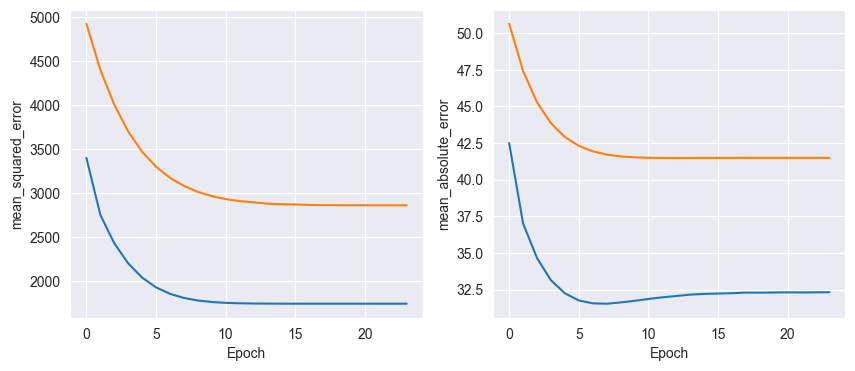

255/255 [==============================] - 13s 49ms/step - loss: 1852.8164 - mean_absolute_error: 33.2255
units: 100, dropout: 0, batch size: 128, optimizer: Adam, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 21s 352ms/step - loss: 3036.3604 - mean_absolute_error: 40.1775 - val_loss: 5102.7412 - val_mean_absolute_error: 52.3962
Epoch 2/100
51/51 [==============================] - 17s 331ms/step - loss: 2451.3813 - mean_absolute_error: 34.9848 - val_loss: 4625.7349 - val_mean_absolute_error: 49.4553
Epoch 3/100
51/51 [==============================] - 17s 334ms/step - loss: 2189.4438 - mean_absolute_error: 32.9453 - val_loss: 4251.8613 - val_mean_absolute_error: 47.3130
Epoch 4/100
51/51 [==============================] - 17s 329ms/step - loss: 1998.6459 - mean_absolute_error: 31.6234 - val_loss: 3954.9597 - val_mean_absolute_error: 45.7414
Epoch 5/100
51/51 [==============================] - 17s 337ms/step - loss: 1859.4574 - mean_absolute_error: 30.7812 -

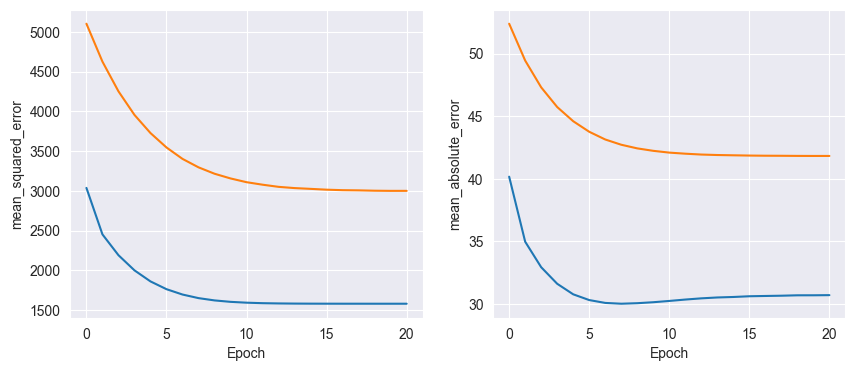

255/255 [==============================] - 12s 47ms/step - loss: 1862.8541 - mean_absolute_error: 32.9362
units: 100, dropout: 0, batch size: 32, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 32s 127ms/step - loss: 2551.5762 - mean_absolute_error: 35.7702 - val_loss: 3556.1987 - val_mean_absolute_error: 43.2435
Epoch 2/100
229/229 [==============================] - 29s 126ms/step - loss: 1830.1277 - mean_absolute_error: 31.7248 - val_loss: 2905.7346 - val_mean_absolute_error: 41.4809
Epoch 3/100
229/229 [==============================] - 29s 125ms/step - loss: 1741.6427 - mean_absolute_error: 32.1909 - val_loss: 2852.2170 - val_mean_absolute_error: 41.4993
Epoch 4/100
229/229 [==============================] - 29s 125ms/step - loss: 1741.4659 - mean_absolute_error: 32.3047 - val_loss: 2853.4023 - val_mean_absolute_error: 41.4980


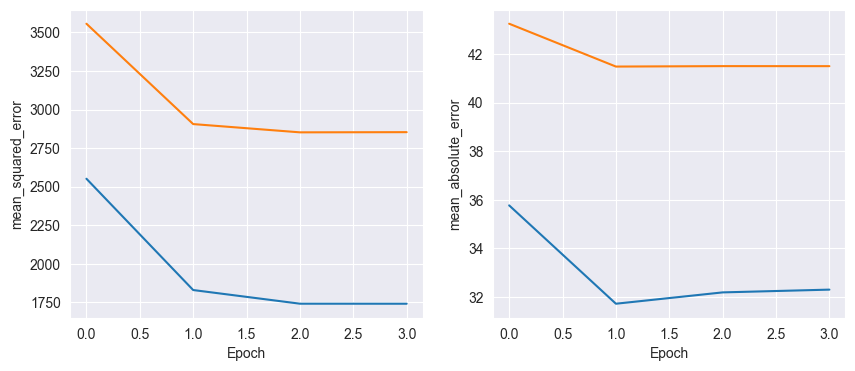

255/255 [==============================] - 11s 45ms/step - loss: 1852.2953 - mean_absolute_error: 33.2738
units: 100, dropout: 0, batch size: 32, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 29s 131ms/step - loss: 2401.5383 - mean_absolute_error: 34.7812 - val_loss: 3910.5532 - val_mean_absolute_error: 45.5144
Epoch 2/100
204/204 [==============================] - 26s 129ms/step - loss: 1691.4038 - mean_absolute_error: 30.2854 - val_loss: 3104.6072 - val_mean_absolute_error: 42.0346
Epoch 3/100
204/204 [==============================] - 27s 134ms/step - loss: 1177.6725 - mean_absolute_error: 22.8959 - val_loss: 2399.4810 - val_mean_absolute_error: 34.4829
Epoch 4/100
204/204 [==============================] - 27s 130ms/step - loss: 696.8738 - mean_absolute_error: 15.3437 - val_loss: 1559.6115 - val_mean_absolute_error: 24.3226
Epoch 5/100
204/204 [==============================] - 27s 131ms/step - loss: 480.6834 - mean_absolute_error:

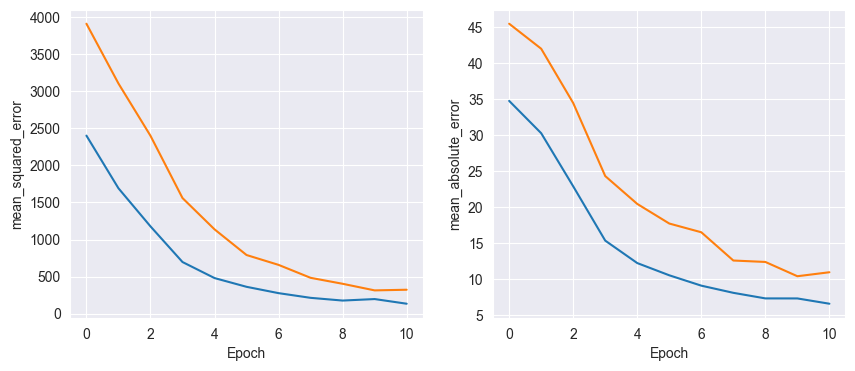

255/255 [==============================] - 11s 44ms/step - loss: 151.9679 - mean_absolute_error: 6.9230
units: 100, dropout: 0, batch size: 64, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 24s 181ms/step - loss: 2878.6655 - mean_absolute_error: 38.1729 - val_loss: 4260.2544 - val_mean_absolute_error: 46.6221
Epoch 2/100
115/115 [==============================] - 21s 179ms/step - loss: 2218.9001 - mean_absolute_error: 33.3156 - val_loss: 3525.9331 - val_mean_absolute_error: 43.1227
Epoch 3/100
115/115 [==============================] - 21s 181ms/step - loss: 1873.4419 - mean_absolute_error: 31.6615 - val_loss: 3057.5579 - val_mean_absolute_error: 41.6654
Epoch 4/100
115/115 [==============================] - 20s 177ms/step - loss: 1753.8551 - mean_absolute_error: 31.8720 - val_loss: 2885.7156 - val_mean_absolute_error: 41.4792
Epoch 5/100
115/115 [==============================] - 20s 177ms/step - loss: 1741.4639 - mean_absolute_error:

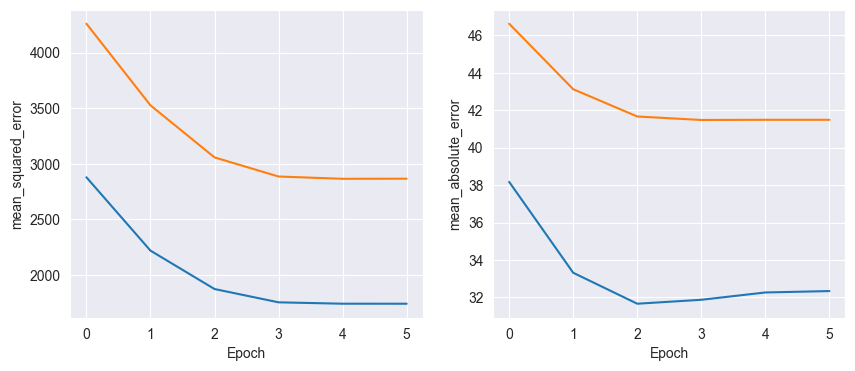

255/255 [==============================] - 11s 43ms/step - loss: 1853.5498 - mean_absolute_error: 33.1942
units: 100, dropout: 0, batch size: 64, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 22s 183ms/step - loss: 2703.0107 - mean_absolute_error: 37.1483 - val_loss: 4675.5718 - val_mean_absolute_error: 49.7545
Epoch 2/100
102/102 [==============================] - 19s 187ms/step - loss: 2108.6187 - mean_absolute_error: 32.3913 - val_loss: 3925.9197 - val_mean_absolute_error: 45.5927
Epoch 3/100
102/102 [==============================] - 19s 185ms/step - loss: 1766.2389 - mean_absolute_error: 30.3566 - val_loss: 3370.2341 - val_mean_absolute_error: 43.0205
Epoch 4/100
102/102 [==============================] - 19s 187ms/step - loss: 1611.8198 - mean_absolute_error: 30.1502 - val_loss: 3095.5901 - val_mean_absolute_error: 42.0647
Epoch 5/100
102/102 [==============================] - 19s 191ms/step - loss: 1568.8600 - mean_absolute_erro

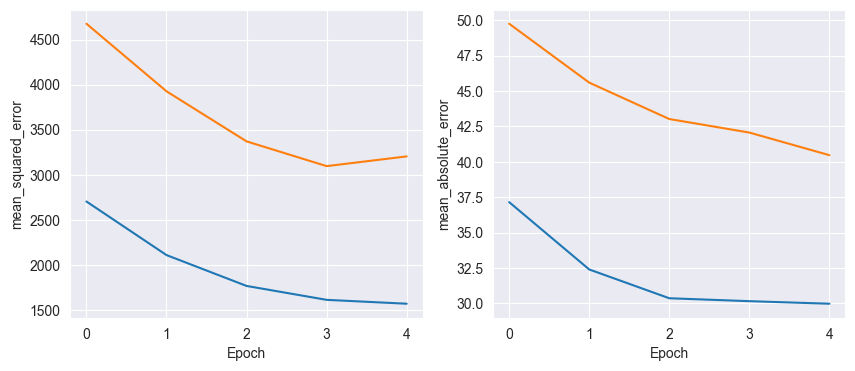

255/255 [==============================] - 11s 44ms/step - loss: 1793.1481 - mean_absolute_error: 28.7120
units: 100, dropout: 0, batch size: 128, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 21s 311ms/step - loss: 3066.5950 - mean_absolute_error: 39.6593 - val_loss: 4650.4697 - val_mean_absolute_error: 48.9032
Epoch 2/100
58/58 [==============================] - 17s 288ms/step - loss: 2577.7542 - mean_absolute_error: 35.7466 - val_loss: 4177.4253 - val_mean_absolute_error: 46.1707
Epoch 3/100
58/58 [==============================] - 17s 294ms/step - loss: 2282.0603 - mean_absolute_error: 33.6498 - val_loss: 3779.8445 - val_mean_absolute_error: 44.2047
Epoch 4/100
58/58 [==============================] - 17s 298ms/step - loss: 2056.5554 - mean_absolute_error: 32.3276 - val_loss: 3450.2776 - val_mean_absolute_error: 42.8320
Epoch 5/100
58/58 [==============================] - 17s 290ms/step - loss: 1895.2762 - mean_absolute_error: 31.662

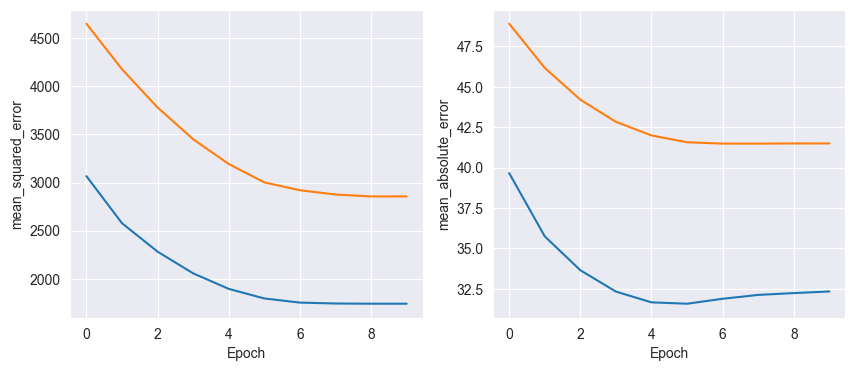

255/255 [==============================] - 11s 43ms/step - loss: 1852.5398 - mean_absolute_error: 33.2542
units: 100, dropout: 0, batch size: 128, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 19s 325ms/step - loss: 2844.8198 - mean_absolute_error: 38.3943 - val_loss: 5013.7310 - val_mean_absolute_error: 51.8337
Epoch 2/100
51/51 [==============================] - 16s 314ms/step - loss: 2408.1311 - mean_absolute_error: 34.6392 - val_loss: 4564.2798 - val_mean_absolute_error: 49.0934
Epoch 3/100
51/51 [==============================] - 16s 306ms/step - loss: 2151.0740 - mean_absolute_error: 32.6722 - val_loss: 4174.4355 - val_mean_absolute_error: 46.8916
Epoch 4/100
51/51 [==============================] - 16s 310ms/step - loss: 1943.8693 - mean_absolute_error: 31.2905 - val_loss: 3829.6982 - val_mean_absolute_error: 45.1108
Epoch 5/100
51/51 [==============================] - 16s 308ms/step - loss: 1784.8304 - mean_absolute_error: 30.405

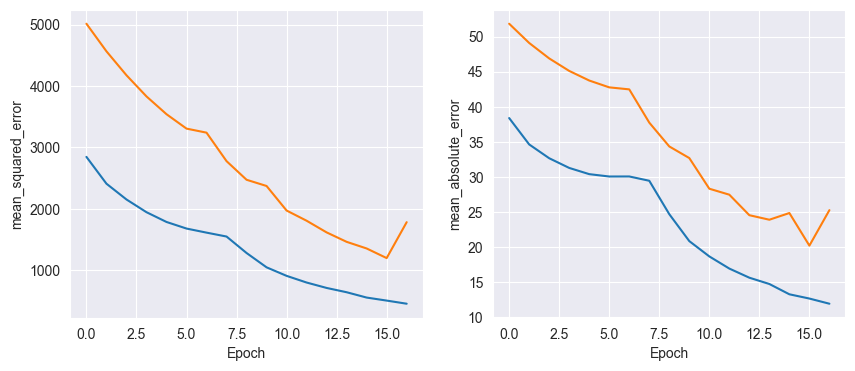

255/255 [==============================] - 11s 45ms/step - loss: 1210.3875 - mean_absolute_error: 20.0153
units: 100, dropout: 0.2, batch size: 32, optimizer: SGD, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 32s 126ms/step - loss: 1619.1162 - mean_absolute_error: 30.4093 - val_loss: 1116.6520 - val_mean_absolute_error: 24.1459
Epoch 2/100
229/229 [==============================] - 29s 125ms/step - loss: 773.6017 - mean_absolute_error: 19.4163 - val_loss: 1045.1334 - val_mean_absolute_error: 22.5690
Epoch 3/100
229/229 [==============================] - 29s 126ms/step - loss: 1530.8285 - mean_absolute_error: 29.1273 - val_loss: 2798.5312 - val_mean_absolute_error: 41.5931


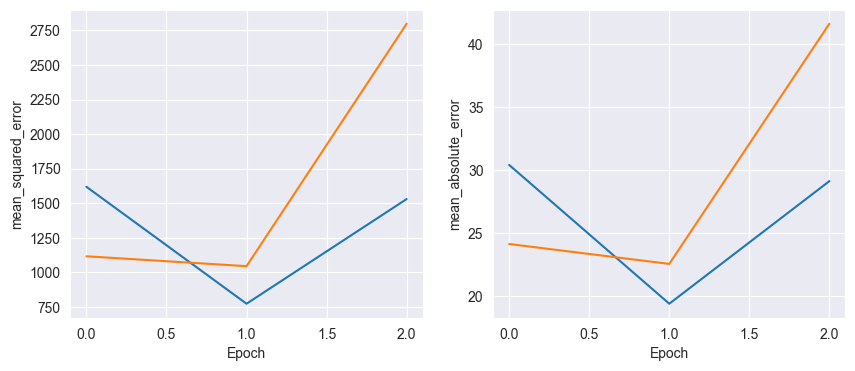

255/255 [==============================] - 11s 41ms/step - loss: 1852.8870 - mean_absolute_error: 33.7227
units: 100, dropout: 0.2, batch size: 32, optimizer: SGD, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 30s 131ms/step - loss: 1670.6237 - mean_absolute_error: 31.3244 - val_loss: 3546.4844 - val_mean_absolute_error: 43.7262
Epoch 2/100
204/204 [==============================] - 28s 138ms/step - loss: 1045.8231 - mean_absolute_error: 23.3940 - val_loss: 1043.5359 - val_mean_absolute_error: 23.3137
Epoch 3/100
204/204 [==============================] - 27s 135ms/step - loss: 624.3312 - mean_absolute_error: 17.0667 - val_loss: 1021.5773 - val_mean_absolute_error: 22.7804
Epoch 4/100
204/204 [==============================] - 28s 136ms/step - loss: 607.6745 - mean_absolute_error: 16.7397 - val_loss: 1882.6445 - val_mean_absolute_error: 31.9763


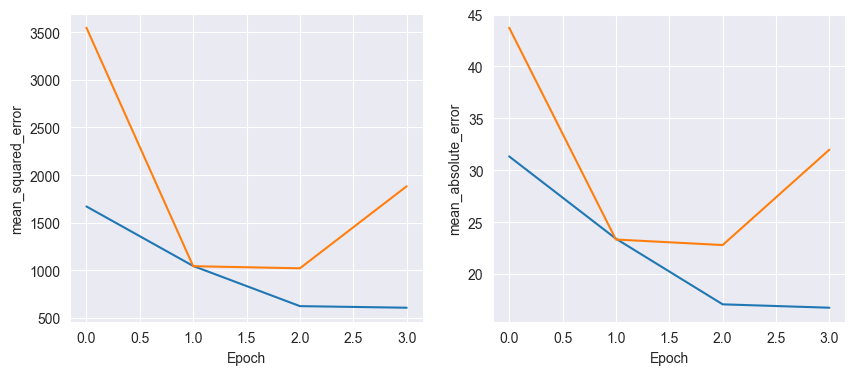

255/255 [==============================] - 11s 44ms/step - loss: 1022.4010 - mean_absolute_error: 21.4662
units: 100, dropout: 0.2, batch size: 64, optimizer: SGD, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 23s 181ms/step - loss: 1820.0444 - mean_absolute_error: 32.8613 - val_loss: 4177.4233 - val_mean_absolute_error: 46.1483
Epoch 2/100
115/115 [==============================] - 21s 182ms/step - loss: 1636.9744 - mean_absolute_error: 30.7402 - val_loss: 2266.8528 - val_mean_absolute_error: 34.1641
Epoch 3/100
115/115 [==============================] - 21s 179ms/step - loss: 920.8238 - mean_absolute_error: 21.9362 - val_loss: 1232.0111 - val_mean_absolute_error: 24.1312
Epoch 4/100
115/115 [==============================] - 21s 182ms/step - loss: 728.2516 - mean_absolute_error: 18.6534 - val_loss: 767.5976 - val_mean_absolute_error: 20.0742
Epoch 5/100
115/115 [==============================] - 21s 183ms/step - loss: 679.5170 - mean_absolute_error: 17.

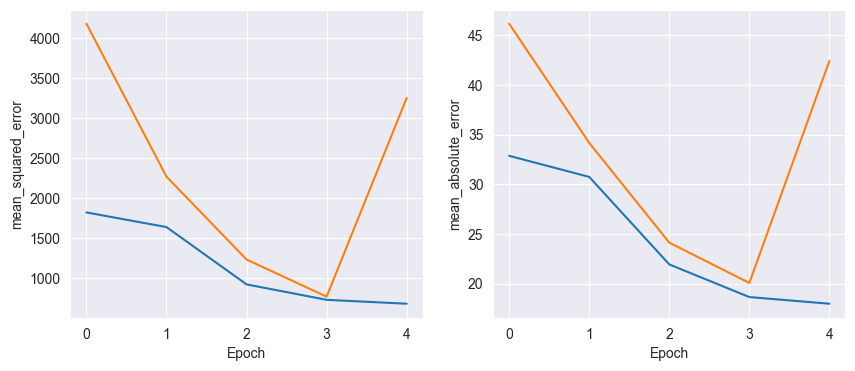

255/255 [==============================] - 11s 43ms/step - loss: 2094.6997 - mean_absolute_error: 33.2844
units: 100, dropout: 0.2, batch size: 64, optimizer: SGD, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 22s 190ms/step - loss: 1678.6556 - mean_absolute_error: 31.4627 - val_loss: 3109.1174 - val_mean_absolute_error: 41.1992
Epoch 2/100
102/102 [==============================] - 20s 198ms/step - loss: 1371.4498 - mean_absolute_error: 27.8279 - val_loss: 2268.8179 - val_mean_absolute_error: 33.8190
Epoch 3/100
102/102 [==============================] - 20s 194ms/step - loss: 698.1327 - mean_absolute_error: 18.2174 - val_loss: 870.3983 - val_mean_absolute_error: 21.7770
Epoch 4/100
102/102 [==============================] - 20s 199ms/step - loss: 600.2233 - mean_absolute_error: 16.4507 - val_loss: 2122.3755 - val_mean_absolute_error: 31.1514


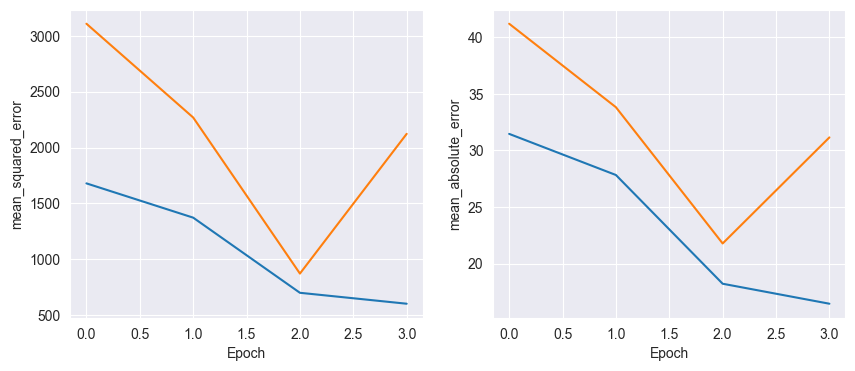

255/255 [==============================] - 11s 44ms/step - loss: 1068.6884 - mean_absolute_error: 19.5994
units: 100, dropout: 0.2, batch size: 128, optimizer: SGD, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 22s 337ms/step - loss: 1883.1990 - mean_absolute_error: 33.2083 - val_loss: 3016.0557 - val_mean_absolute_error: 41.5852
Epoch 2/100
58/58 [==============================] - 18s 318ms/step - loss: 1774.8666 - mean_absolute_error: 32.5610 - val_loss: 2702.6199 - val_mean_absolute_error: 42.1832
Epoch 3/100
58/58 [==============================] - 18s 309ms/step - loss: 1788.5433 - mean_absolute_error: 32.4802 - val_loss: 1753.8156 - val_mean_absolute_error: 30.7879
Epoch 4/100
58/58 [==============================] - 18s 314ms/step - loss: 1635.2103 - mean_absolute_error: 30.8162 - val_loss: 1890.9290 - val_mean_absolute_error: 37.4953


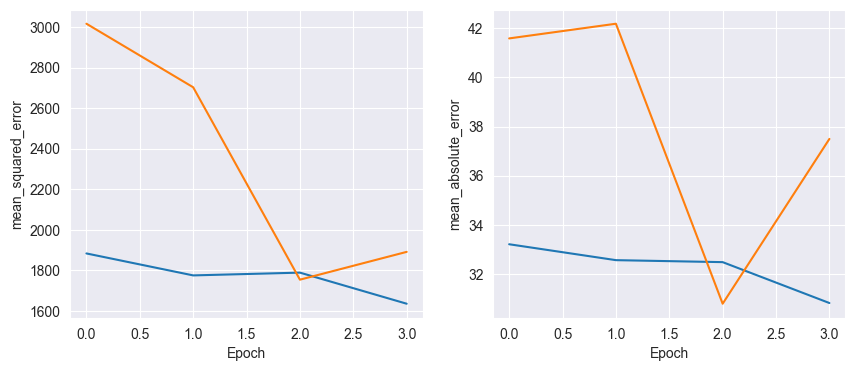

255/255 [==============================] - 11s 44ms/step - loss: 1700.4514 - mean_absolute_error: 36.3220
units: 100, dropout: 0.2, batch size: 128, optimizer: SGD, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 20s 344ms/step - loss: 1721.5421 - mean_absolute_error: 31.7086 - val_loss: 3327.9631 - val_mean_absolute_error: 42.7546
Epoch 2/100
51/51 [==============================] - 17s 340ms/step - loss: 1617.6730 - mean_absolute_error: 30.6075 - val_loss: 2630.0049 - val_mean_absolute_error: 40.0028
Epoch 3/100
51/51 [==============================] - 17s 328ms/step - loss: 1393.2133 - mean_absolute_error: 28.1424 - val_loss: 1435.1842 - val_mean_absolute_error: 28.3107
Epoch 4/100
51/51 [==============================] - 17s 331ms/step - loss: 791.5467 - mean_absolute_error: 19.7888 - val_loss: 943.1554 - val_mean_absolute_error: 22.5785
Epoch 5/100
51/51 [==============================] - 17s 326ms/step - loss: 666.6999 - mean_absolute_error: 17.8642 - v

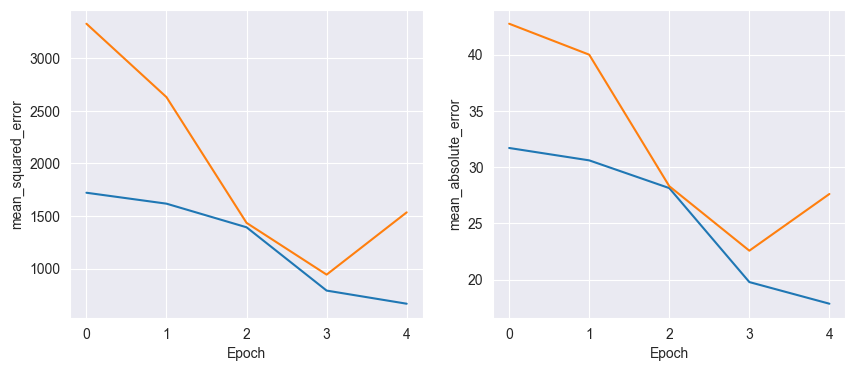

255/255 [==============================] - 12s 45ms/step - loss: 804.1406 - mean_absolute_error: 18.2092
units: 100, dropout: 0.2, batch size: 32, optimizer: Adam, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 33s 133ms/step - loss: 2763.7112 - mean_absolute_error: 37.4050 - val_loss: 3807.8794 - val_mean_absolute_error: 44.3320
Epoch 2/100
229/229 [==============================] - 30s 129ms/step - loss: 1953.1877 - mean_absolute_error: 31.9640 - val_loss: 3140.9895 - val_mean_absolute_error: 41.8537
Epoch 3/100
229/229 [==============================] - 30s 131ms/step - loss: 1773.2273 - mean_absolute_error: 31.7722 - val_loss: 2941.2644 - val_mean_absolute_error: 41.4978
Epoch 4/100
229/229 [==============================] - 29s 129ms/step - loss: 1749.2279 - mean_absolute_error: 32.0923 - val_loss: 2880.8726 - val_mean_absolute_error: 41.4811
Epoch 5/100
229/229 [==============================] - 30s 130ms/step - loss: 1744.1105 - mean_absolute_error:

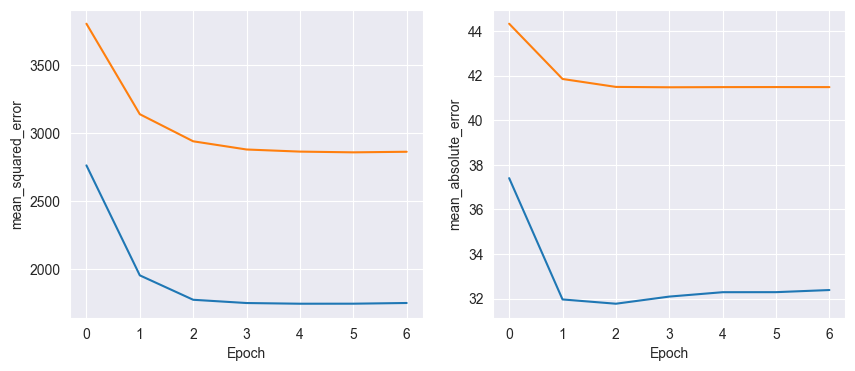

255/255 [==============================] - 13s 52ms/step - loss: 1853.3274 - mean_absolute_error: 33.2047
units: 100, dropout: 0.2, batch size: 32, optimizer: Adam, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 34s 154ms/step - loss: 2557.0742 - mean_absolute_error: 36.0610 - val_loss: 4130.6348 - val_mean_absolute_error: 46.6550
Epoch 2/100
204/204 [==============================] - 40s 195ms/step - loss: 1802.8313 - mean_absolute_error: 30.5585 - val_loss: 3384.4568 - val_mean_absolute_error: 43.0789
Epoch 3/100
204/204 [==============================] - 40s 194ms/step - loss: 1616.2329 - mean_absolute_error: 30.1185 - val_loss: 3111.5654 - val_mean_absolute_error: 42.1102
Epoch 4/100
204/204 [==============================] - 40s 196ms/step - loss: 1588.2640 - mean_absolute_error: 30.5278 - val_loss: 3027.0750 - val_mean_absolute_error: 41.8915
Epoch 5/100
204/204 [==============================] - 40s 196ms/step - loss: 1586.2628 - mean_absolute_error

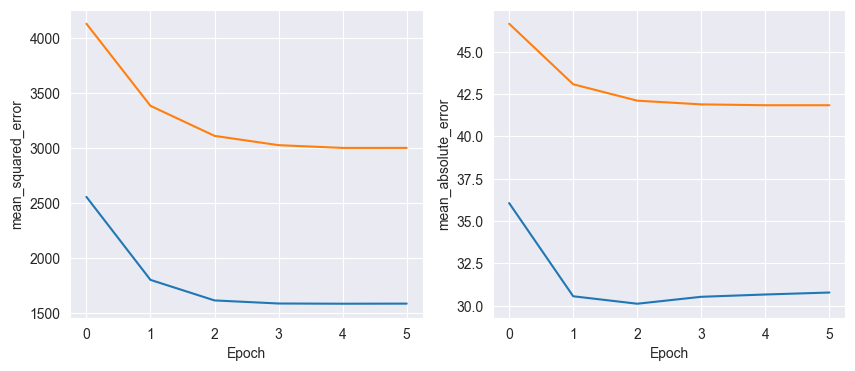

255/255 [==============================] - 15s 58ms/step - loss: 1863.4733 - mean_absolute_error: 32.9262
units: 100, dropout: 0.2, batch size: 64, optimizer: Adam, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 34s 270ms/step - loss: 3082.9114 - mean_absolute_error: 39.7845 - val_loss: 4439.8618 - val_mean_absolute_error: 47.6444
Epoch 2/100
115/115 [==============================] - 31s 265ms/step - loss: 2358.6748 - mean_absolute_error: 34.2270 - val_loss: 3775.0234 - val_mean_absolute_error: 44.1826
Epoch 3/100
115/115 [==============================] - 31s 267ms/step - loss: 2026.4603 - mean_absolute_error: 32.2880 - val_loss: 3362.0762 - val_mean_absolute_error: 42.5183
Epoch 4/100
115/115 [==============================] - 31s 266ms/step - loss: 1859.1036 - mean_absolute_error: 31.6333 - val_loss: 3128.6243 - val_mean_absolute_error: 41.8222
Epoch 5/100
115/115 [==============================] - 31s 267ms/step - loss: 1787.4822 - mean_absolute_error

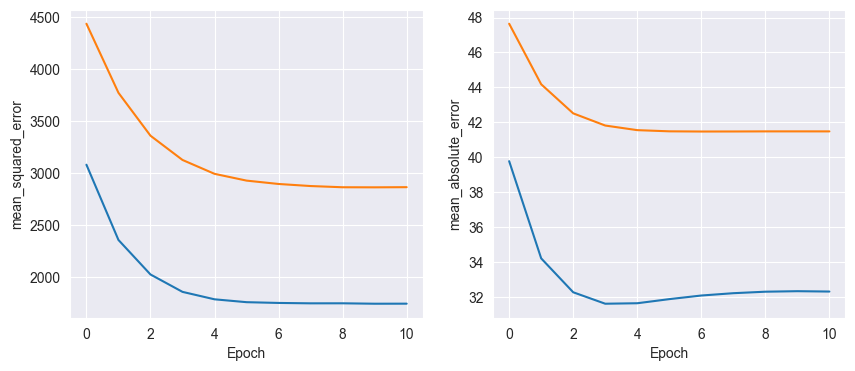

255/255 [==============================] - 14s 55ms/step - loss: 1853.6407 - mean_absolute_error: 33.1897
units: 100, dropout: 0.2, batch size: 64, optimizer: Adam, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 31s 273ms/step - loss: 2861.1133 - mean_absolute_error: 38.5587 - val_loss: 4805.0479 - val_mean_absolute_error: 50.5373
Epoch 2/100
102/102 [==============================] - 27s 265ms/step - loss: 2192.9163 - mean_absolute_error: 33.0147 - val_loss: 4101.9341 - val_mean_absolute_error: 46.5047
Epoch 3/100
102/102 [==============================] - 28s 272ms/step - loss: 1876.6066 - mean_absolute_error: 30.9073 - val_loss: 3654.0923 - val_mean_absolute_error: 44.2631
Epoch 4/100
102/102 [==============================] - 28s 270ms/step - loss: 1714.7119 - mean_absolute_error: 30.1939 - val_loss: 3375.6973 - val_mean_absolute_error: 43.0424
Epoch 5/100
102/102 [==============================] - 27s 270ms/step - loss: 1632.8223 - mean_absolute_error

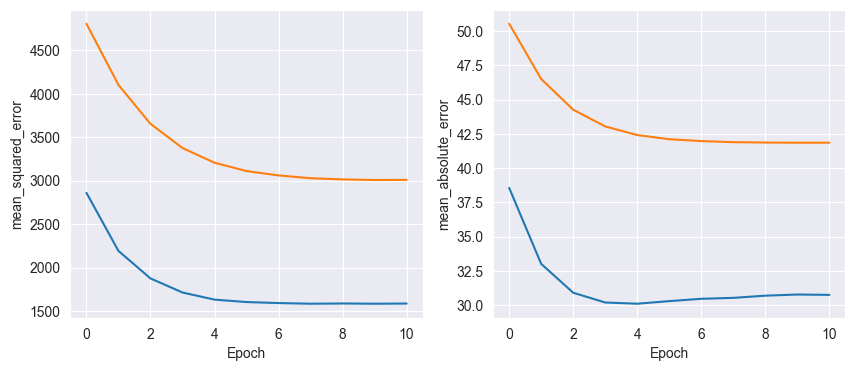

255/255 [==============================] - 14s 54ms/step - loss: 1864.9994 - mean_absolute_error: 32.9025
units: 100, dropout: 0.2, batch size: 128, optimizer: Adam, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 26s 396ms/step - loss: 3419.9971 - mean_absolute_error: 42.6584 - val_loss: 4992.4941 - val_mean_absolute_error: 51.0636
Epoch 2/100
58/58 [==============================] - 22s 377ms/step - loss: 2803.4561 - mean_absolute_error: 37.4796 - val_loss: 4474.1807 - val_mean_absolute_error: 47.8458
Epoch 3/100
58/58 [==============================] - 21s 368ms/step - loss: 2480.6575 - mean_absolute_error: 35.0276 - val_loss: 4077.2869 - val_mean_absolute_error: 45.6443
Epoch 4/100
58/58 [==============================] - 22s 378ms/step - loss: 2247.8591 - mean_absolute_error: 33.4448 - val_loss: 3772.7229 - val_mean_absolute_error: 44.1721
Epoch 5/100
58/58 [==============================] - 22s 376ms/step - loss: 2080.5811 - mean_absolute_error: 32.4635

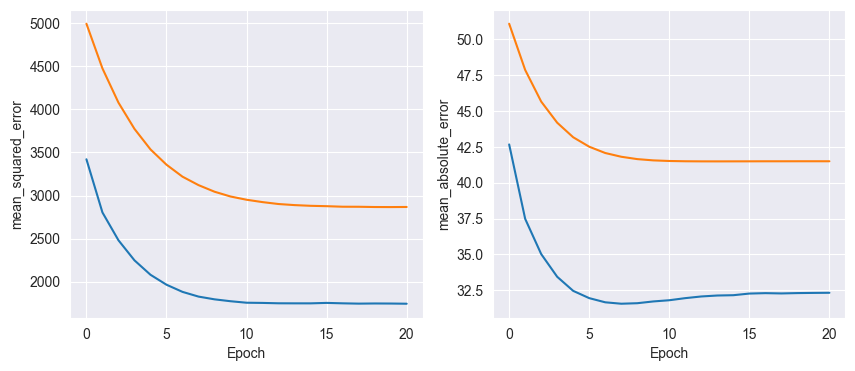

255/255 [==============================] - 14s 56ms/step - loss: 1853.6589 - mean_absolute_error: 33.1888
units: 100, dropout: 0.2, batch size: 128, optimizer: Adam, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 24s 418ms/step - loss: 3084.7097 - mean_absolute_error: 40.4818 - val_loss: 5177.5107 - val_mean_absolute_error: 52.8719
Epoch 2/100
51/51 [==============================] - 20s 395ms/step - loss: 2501.1221 - mean_absolute_error: 35.4297 - val_loss: 4688.8472 - val_mean_absolute_error: 49.8336
Epoch 3/100
51/51 [==============================] - 21s 404ms/step - loss: 2224.3618 - mean_absolute_error: 33.2018 - val_loss: 4299.0220 - val_mean_absolute_error: 47.5727
Epoch 4/100
51/51 [==============================] - 21s 406ms/step - loss: 2025.3987 - mean_absolute_error: 31.7881 - val_loss: 3996.7087 - val_mean_absolute_error: 45.9547
Epoch 5/100
51/51 [==============================] - 20s 396ms/step - loss: 1880.8411 - mean_absolute_error: 30.9199

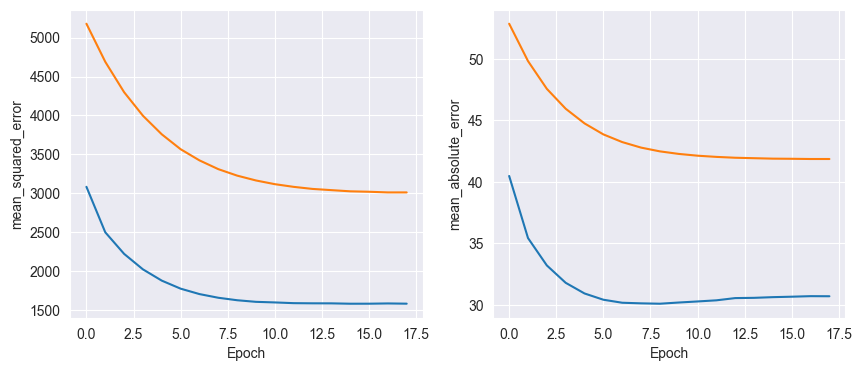

255/255 [==============================] - 14s 56ms/step - loss: 1865.7554 - mean_absolute_error: 32.8912
units: 100, dropout: 0.2, batch size: 32, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
229/229 [==============================] - 42s 172ms/step - loss: 2600.5784 - mean_absolute_error: 36.0872 - val_loss: 3624.4421 - val_mean_absolute_error: 43.5237
Epoch 2/100
229/229 [==============================] - 39s 169ms/step - loss: 1804.2312 - mean_absolute_error: 30.8767 - val_loss: 2524.3733 - val_mean_absolute_error: 33.3261
Epoch 3/100
229/229 [==============================] - 39s 169ms/step - loss: 1270.7943 - mean_absolute_error: 23.9169 - val_loss: 1812.1204 - val_mean_absolute_error: 27.8477
Epoch 4/100
229/229 [==============================] - 38s 167ms/step - loss: 760.1109 - mean_absolute_error: 16.1428 - val_loss: 1291.2358 - val_mean_absolute_error: 25.1909
Epoch 5/100
229/229 [==============================] - 39s 169ms/step - loss: 519.5858 - mean_absolute_erro

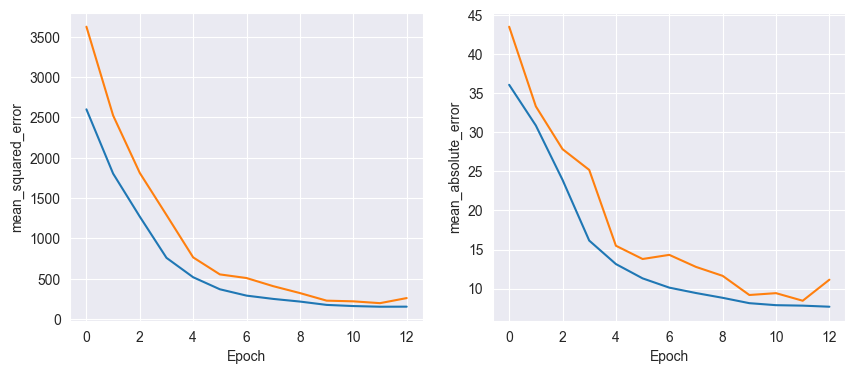

255/255 [==============================] - 13s 52ms/step - loss: 153.8543 - mean_absolute_error: 8.0829
units: 100, dropout: 0.2, batch size: 32, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
204/204 [==============================] - 38s 173ms/step - loss: 2415.9456 - mean_absolute_error: 34.9171 - val_loss: 3952.9814 - val_mean_absolute_error: 45.7314
Epoch 2/100
204/204 [==============================] - 37s 182ms/step - loss: 1710.4287 - mean_absolute_error: 30.2836 - val_loss: 3133.5264 - val_mean_absolute_error: 42.1749
Epoch 3/100
204/204 [==============================] - 36s 177ms/step - loss: 1452.5931 - mean_absolute_error: 27.7418 - val_loss: 2589.8457 - val_mean_absolute_error: 34.7550
Epoch 4/100
204/204 [==============================] - 36s 178ms/step - loss: 862.8875 - mean_absolute_error: 18.0452 - val_loss: 1631.7441 - val_mean_absolute_error: 25.2670
Epoch 5/100
204/204 [==============================] - 36s 175ms/step - loss: 578.0945 - mean_absolute_error:

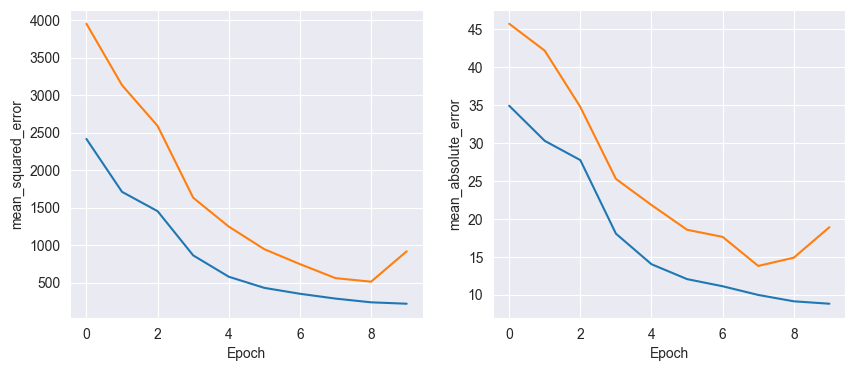

255/255 [==============================] - 13s 52ms/step - loss: 488.5225 - mean_absolute_error: 12.3566
units: 100, dropout: 0.2, batch size: 64, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
115/115 [==============================] - 32s 253ms/step - loss: 2853.8032 - mean_absolute_error: 37.8873 - val_loss: 4231.3882 - val_mean_absolute_error: 46.4656
Epoch 2/100
115/115 [==============================] - 29s 256ms/step - loss: 2211.5730 - mean_absolute_error: 33.2649 - val_loss: 3519.5110 - val_mean_absolute_error: 43.0967
Epoch 3/100
115/115 [==============================] - 29s 257ms/step - loss: 1874.3654 - mean_absolute_error: 31.6931 - val_loss: 3055.9478 - val_mean_absolute_error: 41.6621
Epoch 4/100
115/115 [==============================] - 30s 260ms/step - loss: 1759.2830 - mean_absolute_error: 31.9170 - val_loss: 2894.9919 - val_mean_absolute_error: 41.4800
Epoch 5/100
115/115 [==============================] - 30s 260ms/step - loss: 1750.0598 - mean_absolute_err

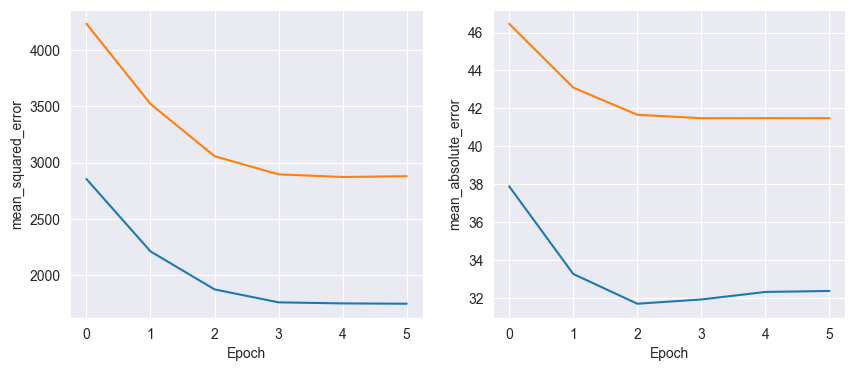

255/255 [==============================] - 14s 55ms/step - loss: 1855.2476 - mean_absolute_error: 33.1216
units: 100, dropout: 0.2, batch size: 64, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
102/102 [==============================] - 30s 264ms/step - loss: 2633.7910 - mean_absolute_error: 36.5776 - val_loss: 4573.8828 - val_mean_absolute_error: 49.1501
Epoch 2/100
102/102 [==============================] - 28s 279ms/step - loss: 2055.4641 - mean_absolute_error: 32.0520 - val_loss: 3834.3469 - val_mean_absolute_error: 45.1336
Epoch 3/100
102/102 [==============================] - 29s 285ms/step - loss: 1738.7526 - mean_absolute_error: 30.2863 - val_loss: 3325.2244 - val_mean_absolute_error: 42.8425
Epoch 4/100
102/102 [==============================] - 29s 285ms/step - loss: 1608.0060 - mean_absolute_error: 30.2353 - val_loss: 3070.7146 - val_mean_absolute_error: 41.9979
Epoch 5/100
102/102 [==============================] - 29s 280ms/step - loss: 1584.2858 - mean_absolute_er

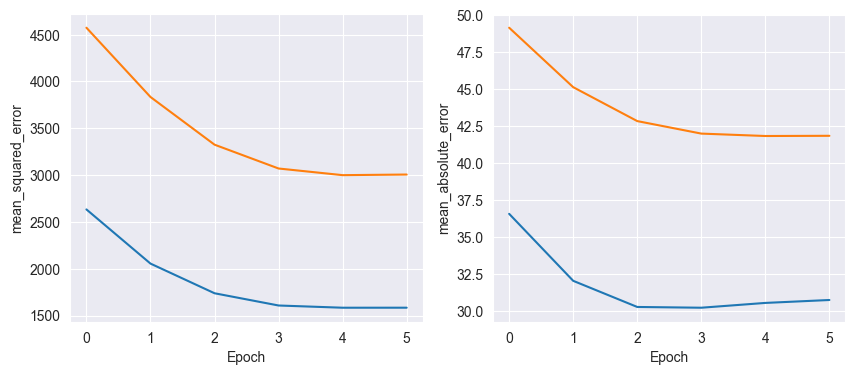

255/255 [==============================] - 14s 55ms/step - loss: 1864.3314 - mean_absolute_error: 32.9127
units: 100, dropout: 0.2, batch size: 128, optimizer: RMSprop, validation_split: 0.1
Epoch 1/100
58/58 [==============================] - 26s 400ms/step - loss: 3166.5791 - mean_absolute_error: 40.4966 - val_loss: 4803.7666 - val_mean_absolute_error: 49.8553
Epoch 2/100
58/58 [==============================] - 22s 378ms/step - loss: 2691.2346 - mean_absolute_error: 36.5295 - val_loss: 4332.4570 - val_mean_absolute_error: 47.0268
Epoch 3/100
58/58 [==============================] - 22s 381ms/step - loss: 2380.0557 - mean_absolute_error: 34.3260 - val_loss: 3919.0046 - val_mean_absolute_error: 44.8539
Epoch 4/100
58/58 [==============================] - 22s 383ms/step - loss: 2132.7026 - mean_absolute_error: 32.7140 - val_loss: 3570.5679 - val_mean_absolute_error: 43.3001
Epoch 5/100
58/58 [==============================] - 22s 375ms/step - loss: 1956.5920 - mean_absolute_error: 31.8

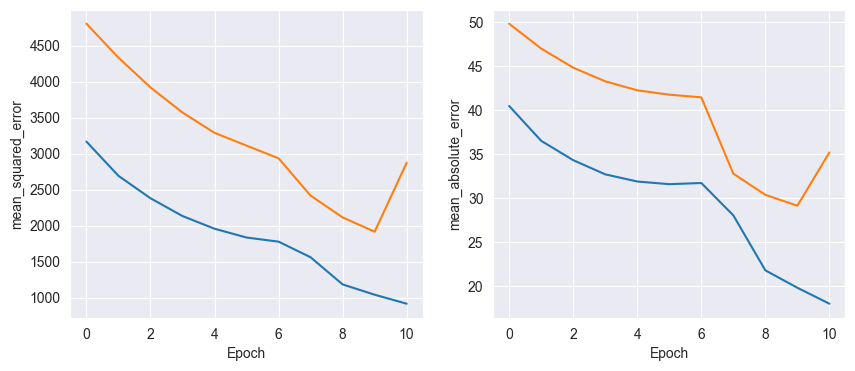

255/255 [==============================] - 14s 54ms/step - loss: 1591.5068 - mean_absolute_error: 25.4216
units: 100, dropout: 0.2, batch size: 128, optimizer: RMSprop, validation_split: 0.2
Epoch 1/100
51/51 [==============================] - 24s 413ms/step - loss: 2843.3696 - mean_absolute_error: 38.3652 - val_loss: 5005.0967 - val_mean_absolute_error: 51.7790
Epoch 2/100
51/51 [==============================] - 21s 405ms/step - loss: 2407.1948 - mean_absolute_error: 34.6287 - val_loss: 4562.0645 - val_mean_absolute_error: 49.0803
Epoch 3/100
51/51 [==============================] - 20s 399ms/step - loss: 2147.5044 - mean_absolute_error: 32.6230 - val_loss: 4165.1416 - val_mean_absolute_error: 46.8416
Epoch 4/100
51/51 [==============================] - 20s 400ms/step - loss: 1937.9248 - mean_absolute_error: 31.2061 - val_loss: 3820.9458 - val_mean_absolute_error: 45.0679
Epoch 5/100
51/51 [==============================] - 21s 406ms/step - loss: 1788.0189 - mean_absolute_error: 30.4

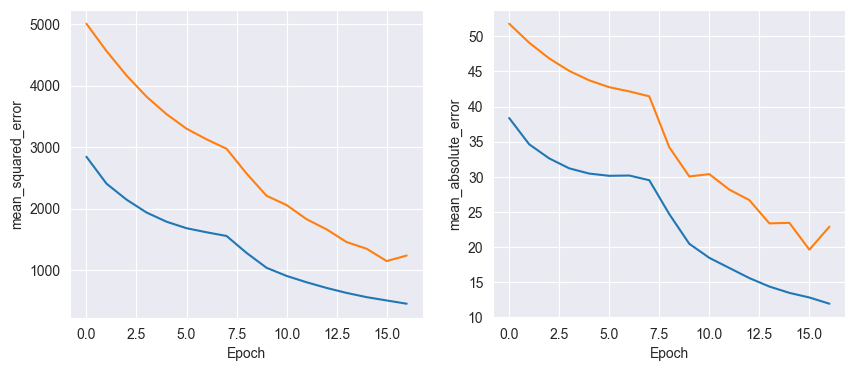

255/255 [==============================] - 14s 56ms/step - loss: 603.2571 - mean_absolute_error: 13.9975


In [326]:
least_val_loss = float('inf')
least_loss_model = None
learning_rate = 0.01
epochs = 100
for units in [50, 100]:
  for dropout_rate in[0, 0.2]:
      # for learning_rate in [1e-4, 1e-2, 'log-uniform']:
        for optimizer in ['SGD', 'Adam', 'RMSprop']:
            # for epochs in [10, 50, 100]:          
                for batch_size in [32, 64, 128]:
                    for validation_split in [0.1, 0.2]:            
                        print(f"units: {units}, dropout: {dropout_rate}, batch size: {batch_size}, optimizer: {optimizer}, validation_split: {validation_split}")
                        model, history = train_model(seq_array, label_rul_array, units, dropout_rate, optimizer, learning_rate, batch_size, epochs, validation_split)
                        plot_history(history)
                        val_loss = model.evaluate(seq_array, label_rul_array)[0]
                        if val_loss < least_val_loss:
                          least_val_loss = val_loss
                          least_loss_model = model

In [361]:
print(least_loss_model.summary())
print(history.history.keys())

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_186 (LSTM)             (None, 125, 100)          46800     
                                                                 
 dropout_186 (Dropout)       (None, 125, 100)          0         
                                                                 
 lstm_187 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_187 (Dropout)       (None, 100)               0         
                                                                 
 dense_93 (Dense)            (None, 1)                 101       
                                                                 
Total params: 127301 (497.27 KB)
Trainable params: 127301 (497.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
dict_key

In [348]:
least_loss_model

In [328]:
# Процесс обучения модели нейронной сети
# model.fit(seq_array, label_rul_array, epochs=50, batch_size=200, validation_split=0.1, verbose=1,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

# callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)]

# seq_array: input-data / входные данные
# label_array: output-data / выходные данные; предсказания модели
# epochs: одна полная итерация по всему набору обучающих данных. Один проход через весь набор данных считается одной эпохой.
# batch_size: определяет количество образцов обучающих данных, которые будут переданы в сеть для обработки за один раз.
# validation_split=0.05: Доля данных, которая будет использоваться для проверки во время обучения. (Во время каждой эпохи процесс 
# обучения будет вычислять потери и метрики на валидационном наборе данных, чтобы оценить, как хорошо модель обобщает данные, которые она еще не видела.)
# verbose=1: В этом режиме модель будет выводить прогресс обучения для каждой эпохи, включая информацию о потерях и метриках.
# callbacks: Список обратных вызовов, которые могут выполняться во время обучения. В данном случае используется обратный вызов 
# EarlyStopping, который остановит обучение, если значение функции потерь на проверочном наборе данных не улучшается.

In [349]:
# Оценка производительности модели на обучающем наборе данных. Метод evaluate 
# вычисляет потери и метрики модели для переданных данных. В данном случае, seq_array 
# представляет собой входные данные, а label_array - соответствующие этим входным данным метки.

scores = least_loss_model.evaluate(seq_array, label_rul_array, verbose=1, batch_size=100)
print('Accurracy: {}'.format(scores[1]))

82/82 [==============================] - 11s 128ms/step - loss: 151.9679 - mean_absolute_error: 6.9230
Accurracy: 6.9230170249938965


In [350]:
# Прогнозирование результатов и вычисление матрицы-путаницы на обучающих данных

# использование метода predict для получения вероятностей
y_pred = least_loss_model.predict(seq_array, batch_size=100)

# Сохранение истинных меток в y_true
y_true = label_rul_array

# Вычисление MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


82/82 [==============================] - 11s 120ms/step
Mean Absolute Error (MAE): 6.923017501831055


In [351]:
# Расчет метрик precision (точность) и recall (полнота)

# Вычисление MSE
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 151.96786499023438


In [363]:
combined_array = np.column_stack((y_true, y_pred))
combined_array

array([[66.       , 53.62131  ],
       [65.       , 53.164795 ],
       [64.       , 53.562527 ],
       ...,
       [ 2.       ,  2.1052055],
       [ 1.       ,  1.447077 ],
       [ 0.       ,  0.9480994]], dtype=float32)

In [353]:
new_seq_array_test_last = seq_array
# использование метода predict для получения вероятностей
y_pred_test_prob = least_loss_model.predict(new_seq_array_test_last)
y_pred_test_prob

255/255 [==============================] - 17s 69ms/step


array([[53.62131  ],
       [53.164795 ],
       [53.562527 ],
       ...,
       [ 2.1052065],
       [ 1.447078 ],
       [ 0.9480988]], dtype=float32)

In [354]:
# Генерация последовательностей
sequence_length_test = 30
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length_test:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length_test]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(100, 30, 16)

In [355]:
# Создаем маску, которая позволяет выбрать только те данные, для которых количество записей по
# идентификатору больше или равно значению переменной sequence_length.

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length_test for id in test_df['id'].unique()]

# Генерация меток
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(100, 1)

In [356]:
# Прогнозирование результатов и вычисление матрицы-путаницы на тестировочных данных

# использование метода predict для получения вероятностей
y_pred_test = least_loss_model.predict(seq_array_test_last, batch_size=128)

# Сохранение истинных меток в y_true

y_true_test = label_array_test_last


1/1 [==============================] - 1s 1s/step


In [357]:
combined_array = np.column_stack((y_true_test, y_pred_test))
combined_array

array([[112.       ,  97.27084  ],
       [ 98.       ,  97.173096 ],
       [ 69.       ,  65.58588  ],
       [ 82.       ,  76.55278  ],
       [ 91.       ,  98.71961  ],
       [ 93.       , 105.553696 ],
       [ 91.       , 133.61331  ],
       [ 95.       , 109.57149  ],
       [111.       , 104.561195 ],
       [ 96.       , 127.97841  ],
       [ 97.       ,  88.42053  ],
       [124.       , 128.1424   ],
       [ 95.       , 118.22587  ],
       [107.       ,  97.15664  ],
       [ 83.       ,  99.29341  ],
       [ 84.       , 113.12632  ],
       [ 50.       ,  52.534775 ],
       [ 28.       ,  40.5243   ],
       [ 87.       , 114.52109  ],
       [ 16.       ,  15.227808 ],
       [ 57.       , 125.89327  ],
       [111.       ,  79.93168  ],
       [113.       , 111.7251   ],
       [ 20.       ,  18.39084  ],
       [145.       ,  98.22304  ],
       [119.       , 118.70276  ],
       [ 66.       ,  91.07535  ],
       [ 97.       , 116.60219  ],
       [ 90.       ,

In [359]:
linreg_metrics = get_regression_metrics('LSTM', y_true_test, y_pred_test)
linreg_metrics

,LSTM
Root Mean Squared Error,20.648265
Mean Absolute Error,16.023849
R^2,0.753108
Explained Variance,0.754442


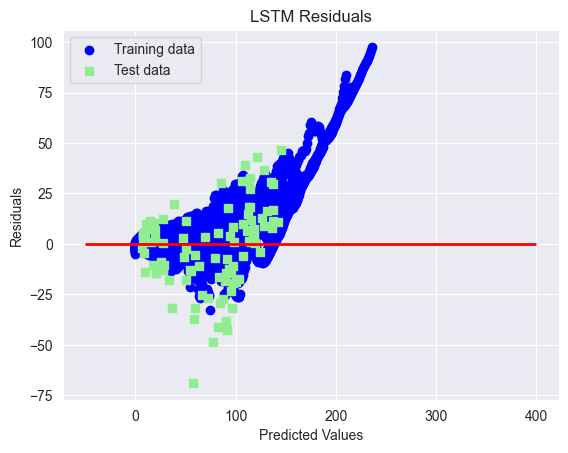

In [360]:
plot_residual('LSTM', y_pred, y_true, y_pred_test, y_true_test)

In [340]:
test_df_RUL = test_df['RUL']
test_df_RUL

0        142
1        141
2        140
3        139
4        138
        ... 
13091     24
13092     23
13093     22
13094     21
13095     20
Name: RUL, Length: 13096, dtype: int64

In [341]:
#try LASSO

features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

X_train = train_df[features]
y_train = train_df['RUL']

X_test = test_df[features]
y_test = test_df['RUL']

from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.580, R^2 test: 0.327


,LASSO
Root Mean Squared Error,48.400840
Mean Absolute Error,37.174757
R^2,0.326515
Explained Variance,0.336648


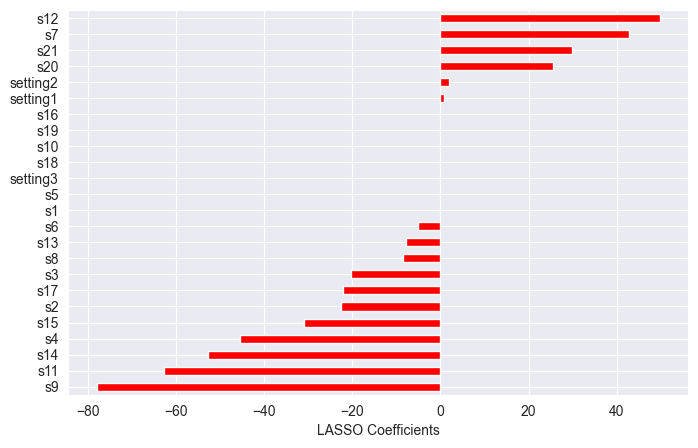

In [342]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

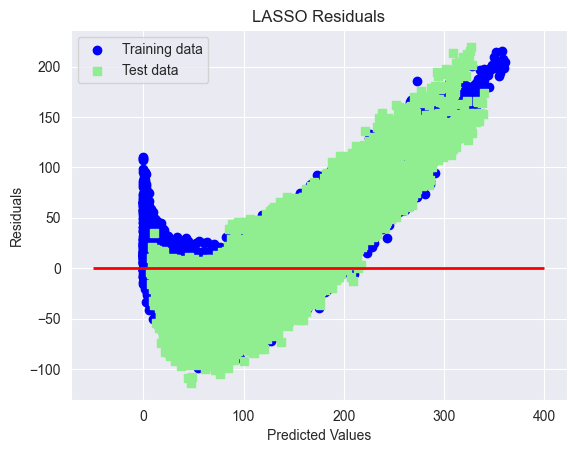

In [343]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

In [344]:
RUL_to_pred = 110
selected_row = test_df.loc[(test_df['id'] == 2) & (test_df['RUL'] == RUL_to_pred)]
selected_row = selected_row[features]
selected_row

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
67,0.522989,0.416667,0.0,0.0,0.599398,0.236756,0.381161,0.0,1.0,0.605475,...,0.65032,0.411765,0.181701,0.357445,0.0,0.416667,0.0,0.0,0.682171,0.543772


In [345]:
predicted_RUL = lasso.predict(selected_row)
predicted_RUL

array([144.05687055])